In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace 202418031_team12.ipynb


[NbConvertApp] WARNING | pattern '202418031_team12.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execut

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from typing import Union
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor



In [ ]:
# drive.mount('/content/drive')
df = pd.read_csv('/content/Tetuan City power consumption.csv')
df.head()


DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119               34055.69620                16128.87538   
1          0.085               29814.68354                19375.07599   
2          0.100               29128.10127                19006.68693   
3          0.096               28228.86076                18361.09422   
4          0.085               27335.69620                17872.34043   

   Zone 3  Power Consumption  
0                20240.96386  
1                20131.08434  
2                19668.43373  
3                18899.27711  
4                18442.40964

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


### Parsing the Datetime column

In [ ]:
df['DateTime'] = df['DateTime'].astype(str)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')
print(df['DateTime'].head())

0   2017-01-01 00:00:00
1   2017-01-01 00:10:00
2   2017-01-01 00:20:00
3   2017-01-01 00:30:00
4   2017-01-01 00:40:00
Name: DateTime, dtype: datetime64[ns]


In [ ]:
df = df[df['DateTime'].notna()]
df.set_index('DateTime', inplace=True)
df.sort_index(inplace=True)


In [ ]:
print(df.index.min(), df.index.max())


2017-01-01 00:00:00 2017-12-30 23:50:00


In [ ]:
df.tail()

Temperature  Humidity  Wind Speed  general diffuse flows  \
DateTime                                                                        
2017-12-30 23:10:00        7.010      72.4       0.080                  0.040   
2017-12-30 23:20:00        6.947      72.6       0.082                  0.051   
2017-12-30 23:30:00        6.900      72.8       0.086                  0.084   
2017-12-30 23:40:00        6.758      73.0       0.080                  0.066   
2017-12-30 23:50:00        6.580      74.1       0.081                  0.062   

                     diffuse flows  Zone 1 Power Consumption  \
DateTime                                                       
2017-12-30 23:10:00          0.096               31160.45627   
2017-12-30 23:20:00          0.093               30430.41825   
2017-12-30 23:30:00          0.074               29590.87452   
2017-12-30 23:40:00          0.089               28958.17490   
2017-12-30 23:50:00          0.111               28349.80989   

                     Zone 2  Power Consumption  Zone 3  Power Consumption  
DateTime                                                                   
2017-12-30 23:10:00                26857.31820                14780.31212  
2017-12-30 23:20:00                26124.57809                14428.81152  
2017-12-30 23:30:00                25277.69254                13806.48259  
2017-12-30 23:40:00                24692.23688                13512.60504  
2017-12-30 23:50:00                24055.23167                13345.49820

In [ ]:
Hourly_avg_zone1 = df["Zone 1 Power Consumption"].resample('H').sum()
Hourly_avg_zone2 = df["Zone 2  Power Consumption"].resample('H').sum()
Hourly_avg_zone3 = df["Zone 3  Power Consumption"].resample('H').sum()


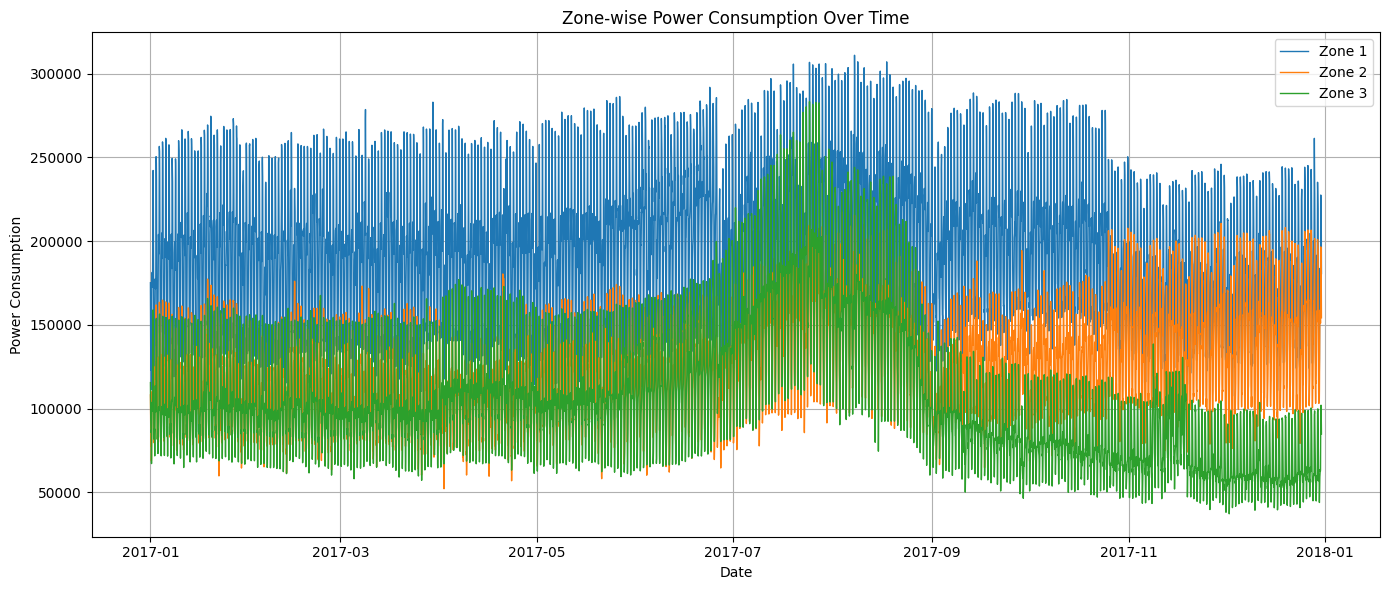

In [ ]:
plt.figure(figsize=(14, 6))

plt.plot(Hourly_avg_zone1.index, Hourly_avg_zone1, label='Zone 1', linewidth=1)
plt.plot(Hourly_avg_zone2.index, Hourly_avg_zone2, label='Zone 2', linewidth=1)
plt.plot(Hourly_avg_zone3.index, Hourly_avg_zone3, label='Zone 3', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.title('Zone-wise Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Weather condition

In [ ]:
df.columns = df.columns.str.strip()
Hourly_temp_stats = df['Temperature'].resample('H').agg(['min', 'max', 'mean'])

In [ ]:
hourly_wind_stats = df.resample('H')['Wind Speed'].agg(['mean'])

In [ ]:
Hourly_humidity = df['Humidity'].resample('H').agg(['mean', 'min', 'max'])
Hourly_humidity

mean    min    max
DateTime                                    
2017-01-01 00:00:00  75.066667  73.80  76.90
2017-01-01 01:00:00  77.583333  76.70  78.20
2017-01-01 02:00:00  78.933333  78.50  79.70
2017-01-01 03:00:00  77.083333  76.20  77.90
2017-01-01 04:00:00  74.050000  71.90  75.70
...                        ...    ...    ...
2017-12-30 19:00:00  62.406667  61.15  63.35
2017-12-30 20:00:00  63.990000  63.38  64.75
2017-12-30 21:00:00  69.675000  65.49  71.70
2017-12-30 22:00:00  70.315000  68.49  71.20
2017-12-30 23:00:00  72.900000  72.40  74.10

[8736 rows x 3 columns]

In [ ]:
Hourly_df = df['diffuse flows'].resample('H').agg(['mean', 'min', 'max'])
Hourly_df

mean    min    max
DateTime                                   
2017-01-01 00:00:00  0.098833  0.085  0.119
2017-01-01 01:00:00  0.112500  0.093  0.141
2017-01-01 02:00:00  0.129167  0.096  0.163
2017-01-01 03:00:00  0.141000  0.108  0.185
2017-01-01 04:00:00  0.122833  0.096  0.148
...                       ...    ...    ...
2017-12-30 19:00:00  0.102000  0.089  0.119
2017-12-30 20:00:00  0.105000  0.085  0.145
2017-12-30 21:00:00  0.098333  0.078  0.134
2017-12-30 22:00:00  0.108167  0.085  0.122
2017-12-30 23:00:00  0.092667  0.074  0.111

[8736 rows x 3 columns]

In [ ]:
Hourly_gdf = df['general diffuse flows'].resample('H').agg(['mean', 'min', 'max'])
Hourly_gdf


mean    min    max
DateTime                                   
2017-01-01 00:00:00  0.063500  0.048  0.091
2017-01-01 01:00:00  0.056833  0.048  0.066
2017-01-01 02:00:00  0.063000  0.051  0.070
2017-01-01 03:00:00  0.059833  0.051  0.070
2017-01-01 04:00:00  0.058000  0.037  0.073
...                       ...    ...    ...
2017-12-30 19:00:00  0.052000  0.037  0.062
2017-12-30 20:00:00  0.052667  0.022  0.073
2017-12-30 21:00:00  0.073167  0.062  0.088
2017-12-30 22:00:00  0.058667  0.037  0.070
2017-12-30 23:00:00  0.060333  0.040  0.084

[8736 rows x 3 columns]

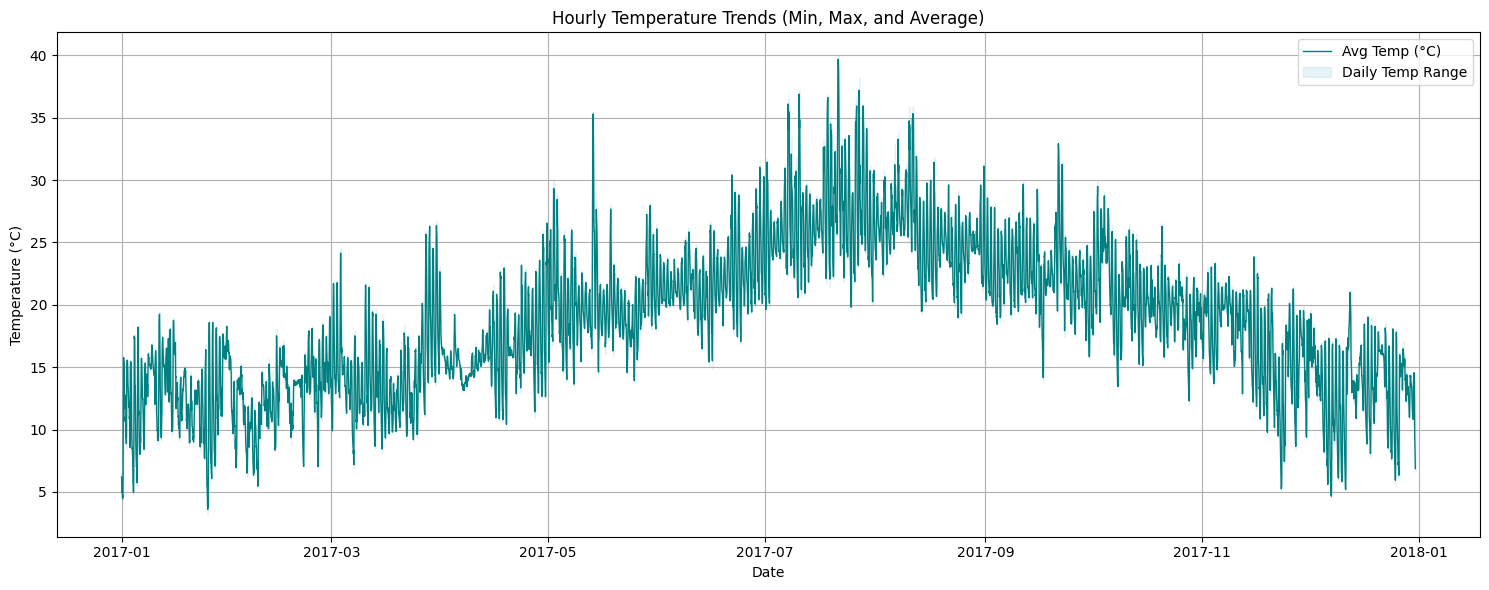

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(Hourly_temp_stats.index, Hourly_temp_stats['mean'], label='Avg Temp (°C)', color='teal', linewidth=1)

plt.fill_between(Hourly_temp_stats.index, Hourly_temp_stats['min'], Hourly_temp_stats['max'],
                 color='lightblue', alpha=0.3, label='Daily Temp Range')

plt.title('Hourly Temperature Trends (Min, Max, and Average)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

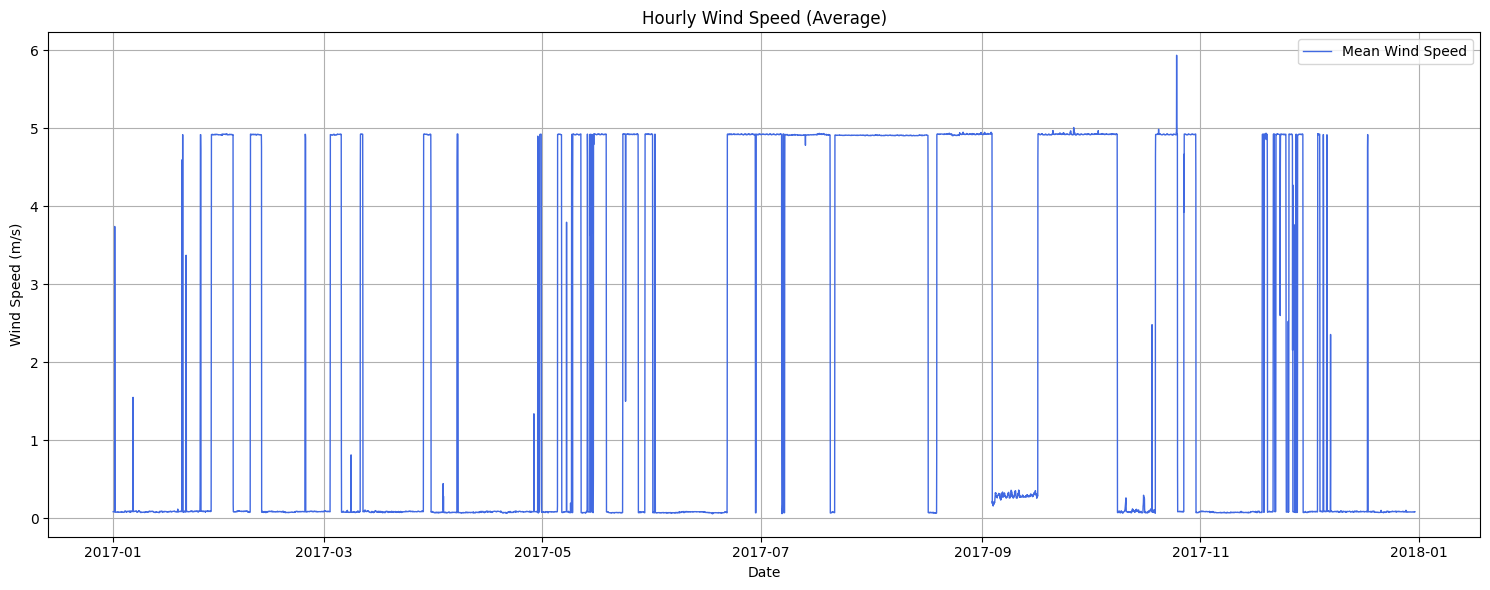

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(hourly_wind_stats.index, hourly_wind_stats['mean'], label='Mean Wind Speed', color='royalblue', linewidth=1)
plt.title('Hourly Wind Speed (Average)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

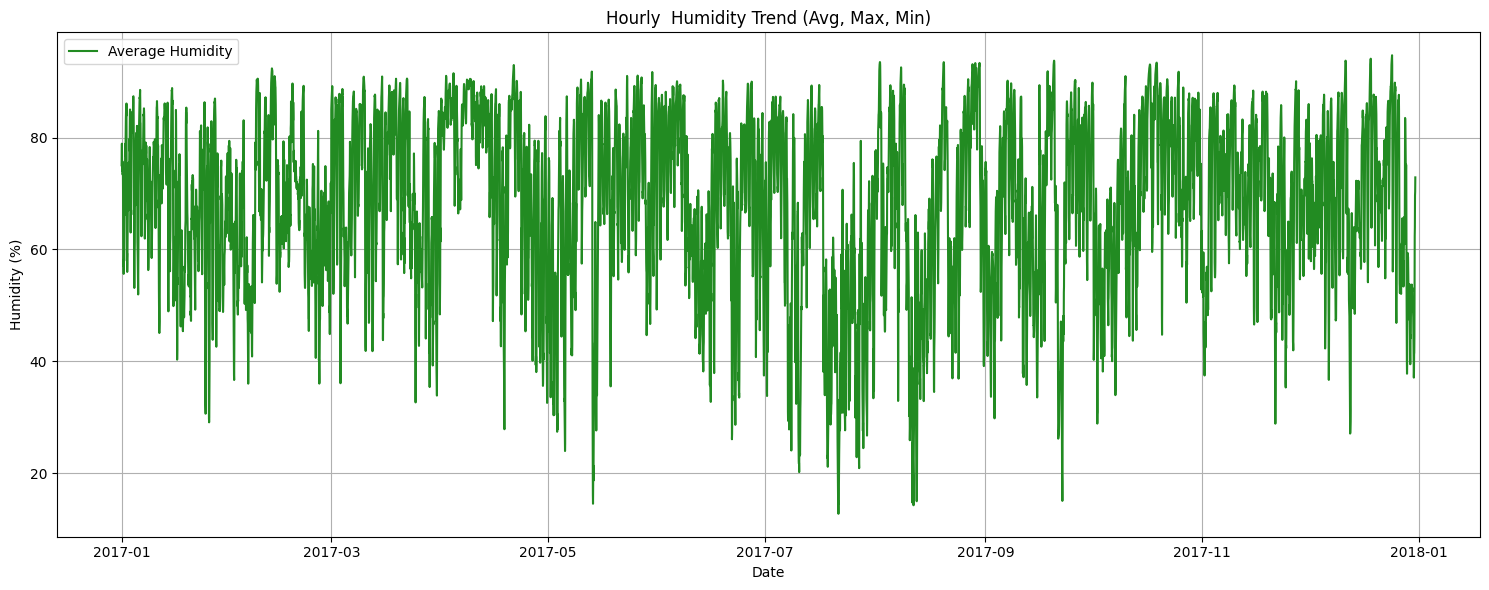

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(Hourly_humidity.index, Hourly_humidity['mean'], label='Average Humidity', color='forestgreen')

plt.title('Hourly  Humidity Trend (Avg, Max, Min)')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


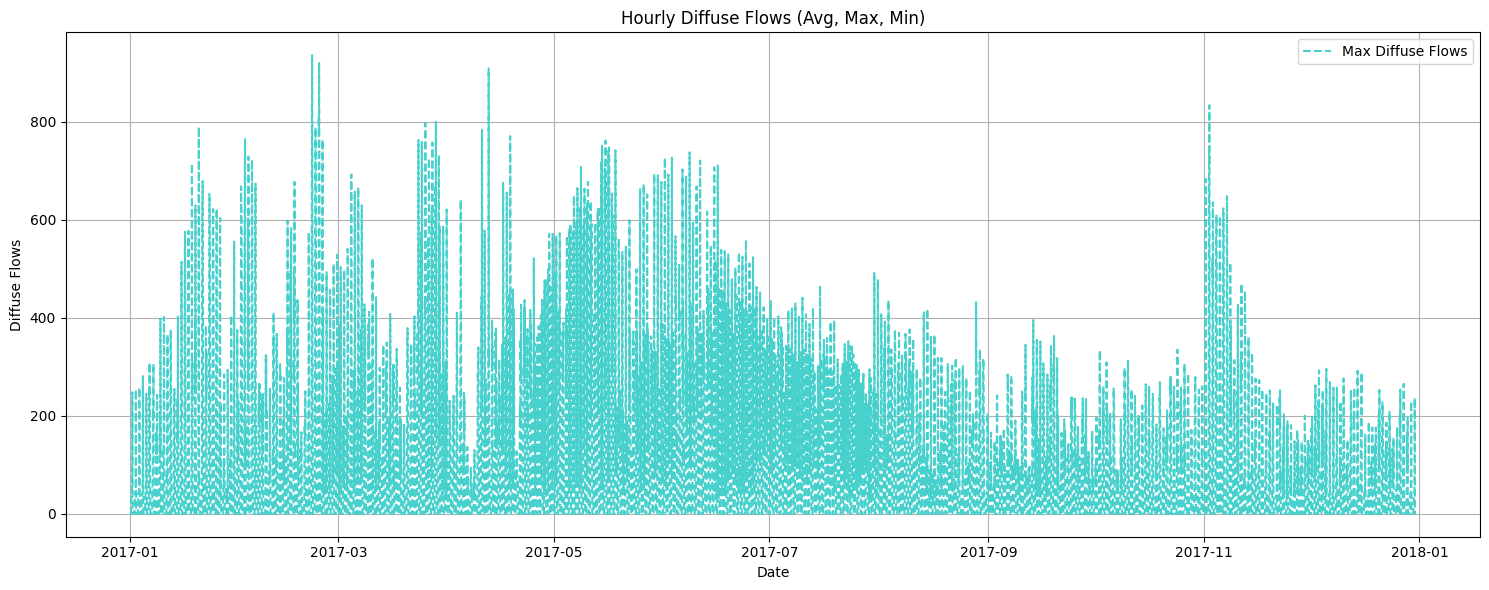

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(Hourly_df.index, Hourly_df['max'], label='Max Diffuse Flows', color='mediumturquoise', linestyle='--')

plt.title('Hourly Diffuse Flows (Avg, Max, Min)')
plt.xlabel('Date')
plt.ylabel('Diffuse Flows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


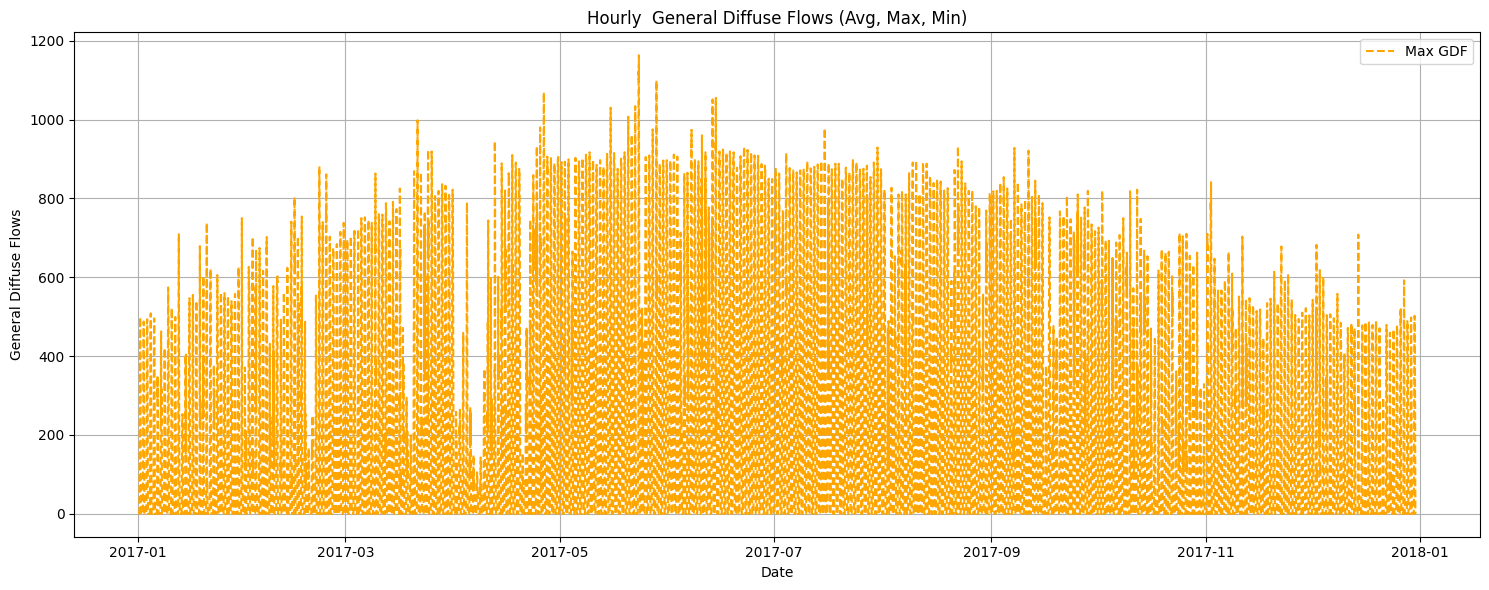

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(Hourly_gdf.index, Hourly_gdf['max'], label='Max GDF', color='orange', linestyle='--')

plt.title('Hourly  General Diffuse Flows (Avg, Max, Min)')
plt.xlabel('Date')
plt.ylabel('General Diffuse Flows')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# EDA

<Figure size 2000x2000 with 0 Axes>

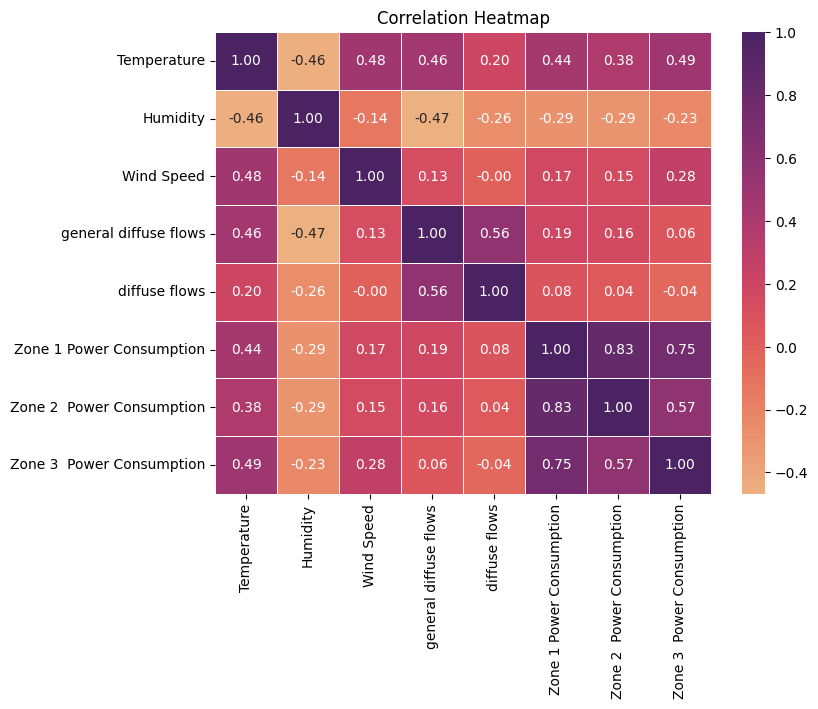

In [ ]:
plt.figure(figsize=(20,20))
corr_matrix = df.select_dtypes(include=['float64', 'int64', 'int32']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='flare', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
final_df = pd.concat([
    Hourly_avg_zone1,
    Hourly_avg_zone2,
    Hourly_avg_zone3,
    Hourly_gdf['max'],
    Hourly_df['max'],
    hourly_wind_stats['mean'],
    Hourly_temp_stats['mean'],
    Hourly_humidity['mean']
], axis=1)

final_df.columns = ['Zone1', 'Zone2', 'Zone3', 'GDF_max', 'DF_max', 'Wind_mean','Temp_mean', 'Humidity_mean']
final_df = final_df.dropna()
final_df[["Zone1", "Zone2", "Zone3"]] = final_df[["Zone1", "Zone2", "Zone3"]] / 1e5


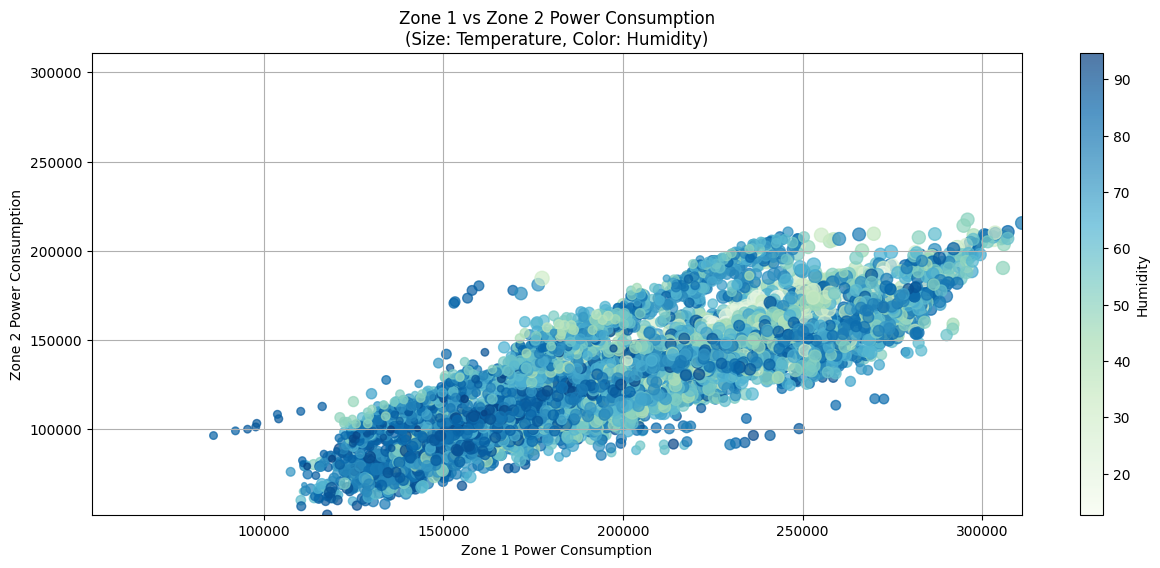

In [ ]:
min_val = min(Hourly_avg_zone1.min(), Hourly_avg_zone2.min())
max_val = max(Hourly_avg_zone1.max(), Hourly_avg_zone2.max())

plt.figure(figsize=(15, 6))

scatter = plt.scatter(
    Hourly_avg_zone1.values,
    Hourly_avg_zone2.values,
    c= Hourly_humidity['mean'],
    s=3 * Hourly_temp_stats['mean'],
    cmap='GnBu',
    alpha=0.7
)

plt.xlabel('Zone 1 Power Consumption')
plt.ylabel('Zone 2 Power Consumption')
plt.title('Zone 1 vs Zone 2 Power Consumption\n(Size: Temperature, Color: Humidity)')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()


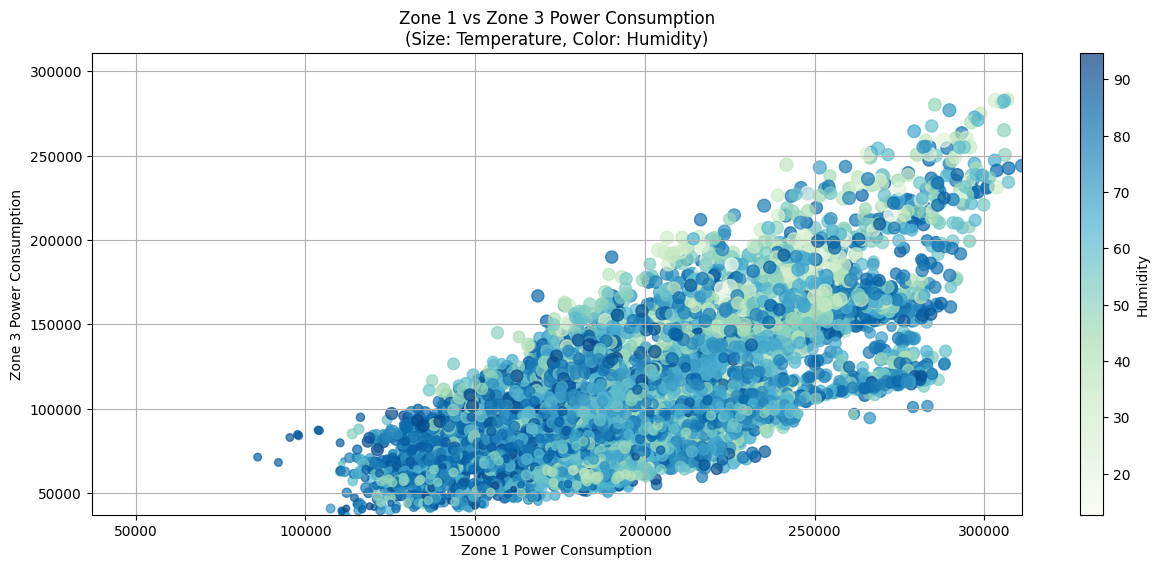

In [ ]:
min_val = min(Hourly_avg_zone1.min(), Hourly_avg_zone3.min())
max_val = max(Hourly_avg_zone1.max(), Hourly_avg_zone3.max())

plt.figure(figsize=(15, 6))

scatter = plt.scatter(
    Hourly_avg_zone1.values,
    Hourly_avg_zone3.values,
    c= Hourly_humidity['mean'],
    s=3 * Hourly_temp_stats['mean'],
    cmap='GnBu',
    alpha=0.7
)

plt.xlabel('Zone 1 Power Consumption')
plt.ylabel('Zone 3 Power Consumption')
plt.title('Zone 1 vs Zone 3 Power Consumption\n(Size: Temperature, Color: Humidity)')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()


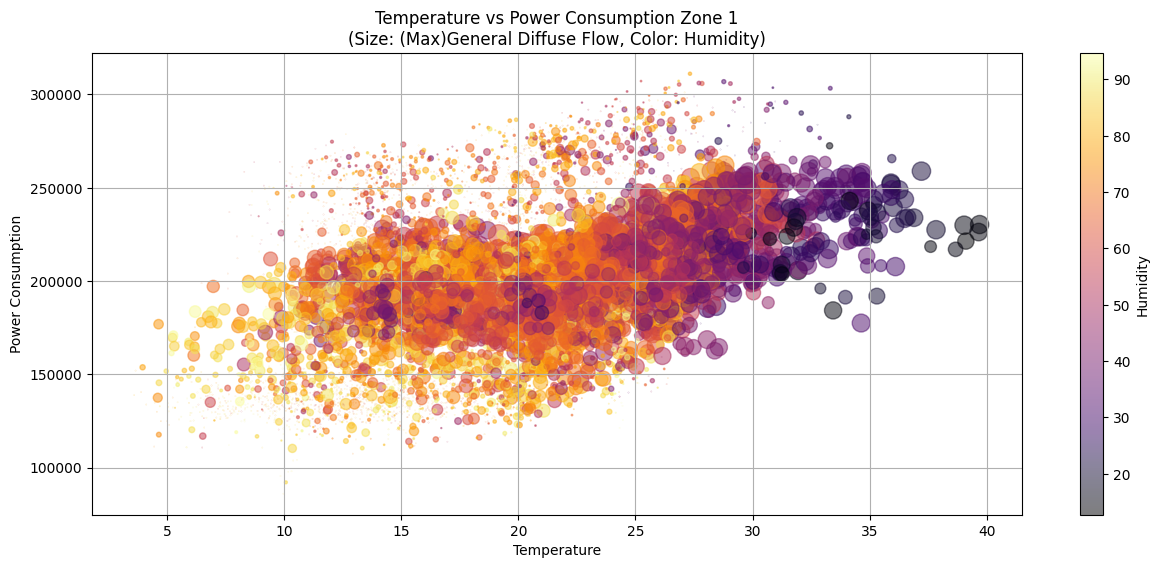

In [ ]:
norm = mcolors.Normalize(vmin=Hourly_humidity['mean'].min(), vmax= Hourly_humidity['mean'].max())

plt.figure(figsize=(15, 6))

scatter = plt.scatter(
    Hourly_temp_stats['mean'],
    Hourly_avg_zone1.values,
    s=0.2 * Hourly_gdf['max'],
    c= Hourly_humidity['mean'],
    cmap='inferno',
    label = 'Zone 1',
    alpha=0.5
)

plt.xlabel('Temperature')
plt.ylabel('Power Consumption')
plt.title('Temperature vs Power Consumption Zone 1\n(Size: (Max)General Diffuse Flow, Color: Humidity)')

cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()

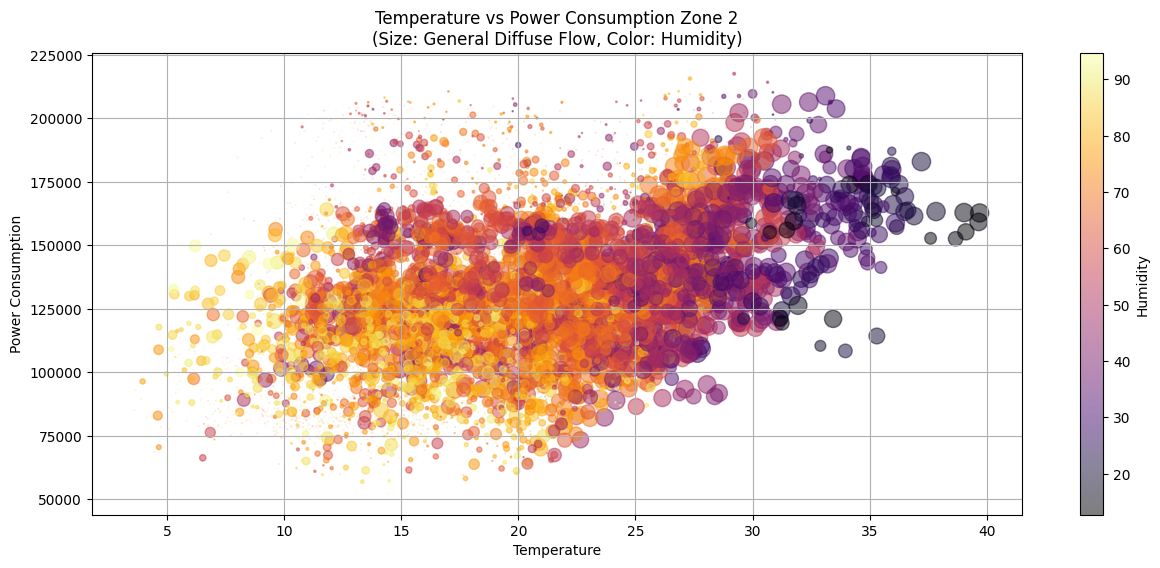

In [ ]:
plt.figure(figsize=(15, 6))

scatter = plt.scatter(
    Hourly_temp_stats['mean'],
    Hourly_avg_zone2.values,
    s=0.2 * Hourly_gdf['max'],
    c=Hourly_humidity['mean'],
    label= 'Zone 2',
    cmap='inferno',
    alpha=0.5
)

plt.xlabel('Temperature')
plt.ylabel('Power Consumption')
plt.title('Temperature vs Power Consumption Zone 2\n(Size: General Diffuse Flow, Color: Humidity)')

cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()

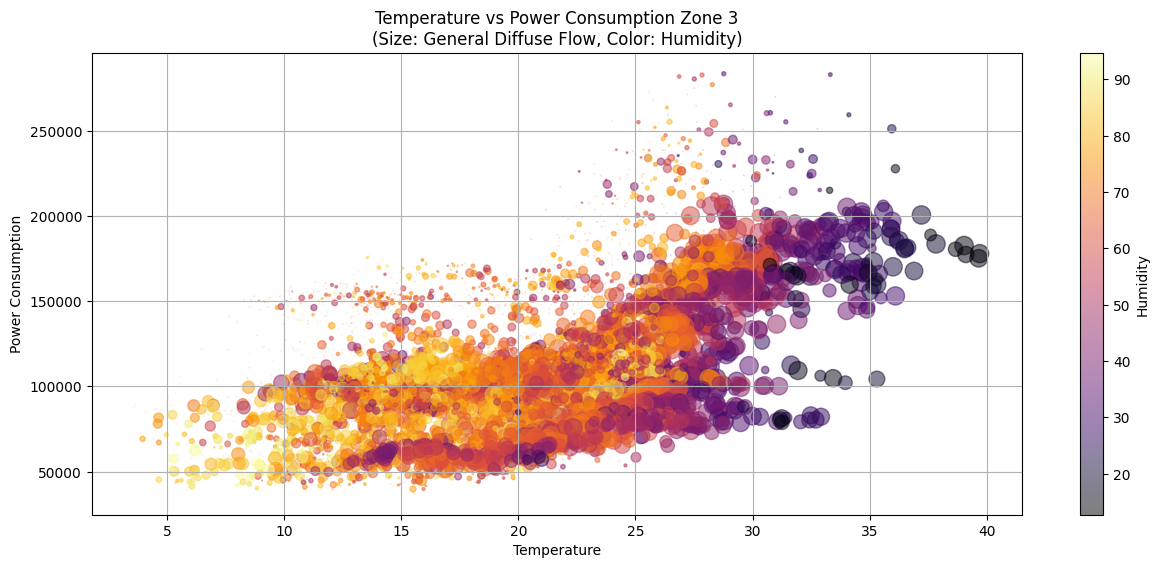

In [ ]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    Hourly_temp_stats['mean'],
    Hourly_avg_zone3.values,
    s=0.2 * Hourly_gdf['max'],
    c= Hourly_humidity['mean'],
    cmap='inferno',
    label = 'Zone 3',
    alpha=0.5
)

plt.xlabel('Temperature')
plt.ylabel('Power Consumption')
plt.title('Temperature vs Power Consumption Zone 3\n(Size: General Diffuse Flow, Color: Humidity)')
cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()

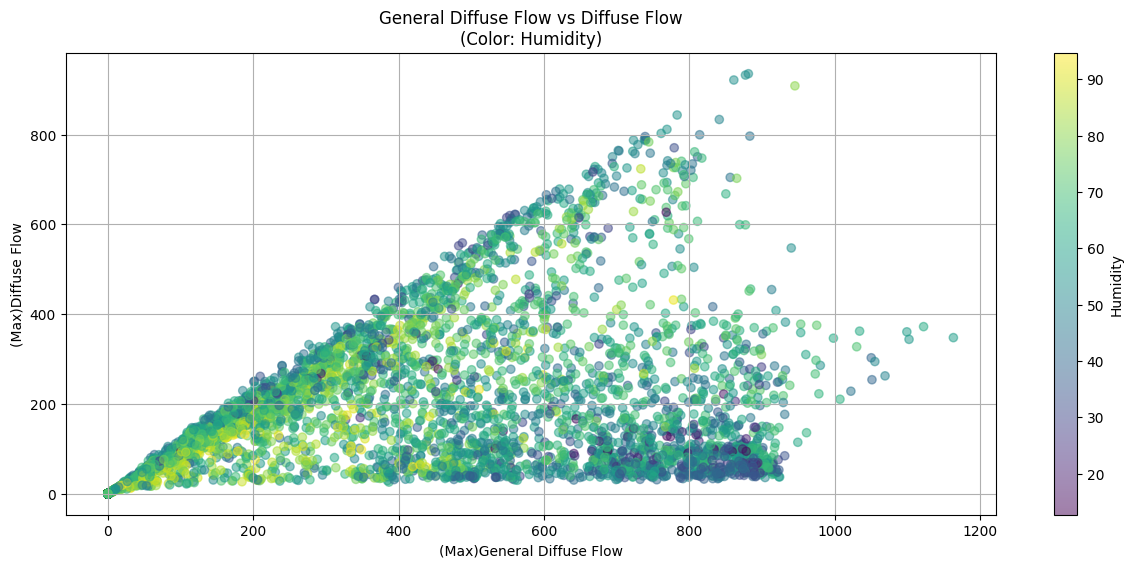

In [ ]:
plt.figure(figsize=(15, 6))

scatter = plt.scatter(
    Hourly_gdf['max'],
    Hourly_df['max'],
    c=Hourly_humidity['mean'],
    cmap='viridis',
    alpha=0.5
)

plt.xlabel('(Max)General Diffuse Flow')
plt.ylabel('(Max)Diffuse Flow')
plt.title('General Diffuse Flow vs Diffuse Flow\n(Color: Humidity)')

cbar = plt.colorbar(scatter)
cbar.set_label('Humidity')

plt.grid(True)
plt.show()

In [ ]:
def decompose_monthly_timeseries(df, target_column, month, period=24):
    monthly_series = df[df.index.month == month][target_column]

    if monthly_series.empty:
        print(f"No data found for month {month} in column '{target_column}'")
        return

    try:
        result = seasonal_decompose(monthly_series, model='additive', period=period)
        fig = result.plot()
        fig.set_size_inches(10, 6)
        plt.suptitle(f'Seasonal Decomposition of {target_column} - {monthly_series.index[0].strftime("%B")}', fontsize=16)
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Decomposition failed: {e}")


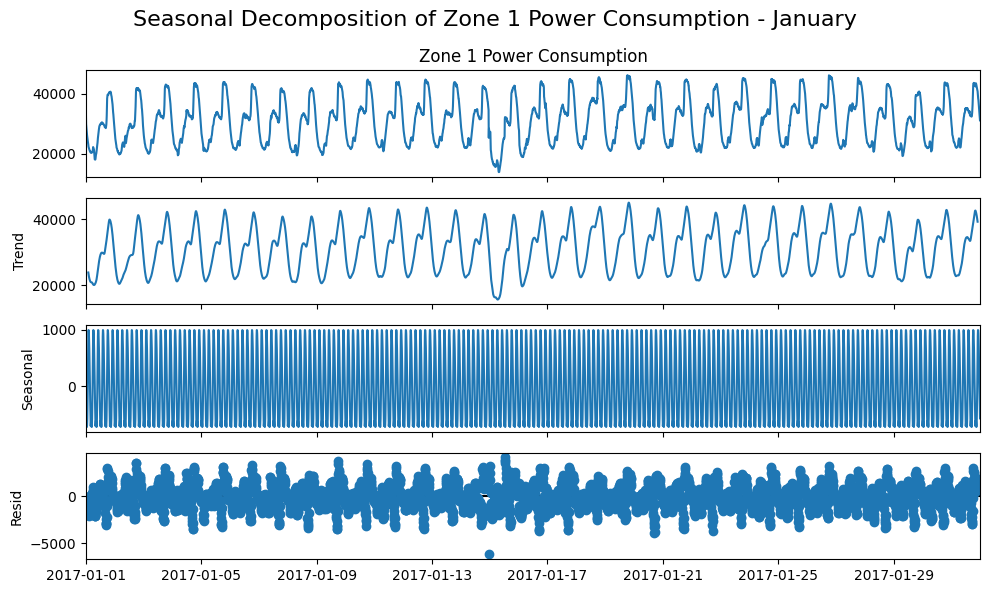

In [ ]:
decompose_monthly_timeseries(df, target_column='Zone 1 Power Consumption', month=1, period=24)


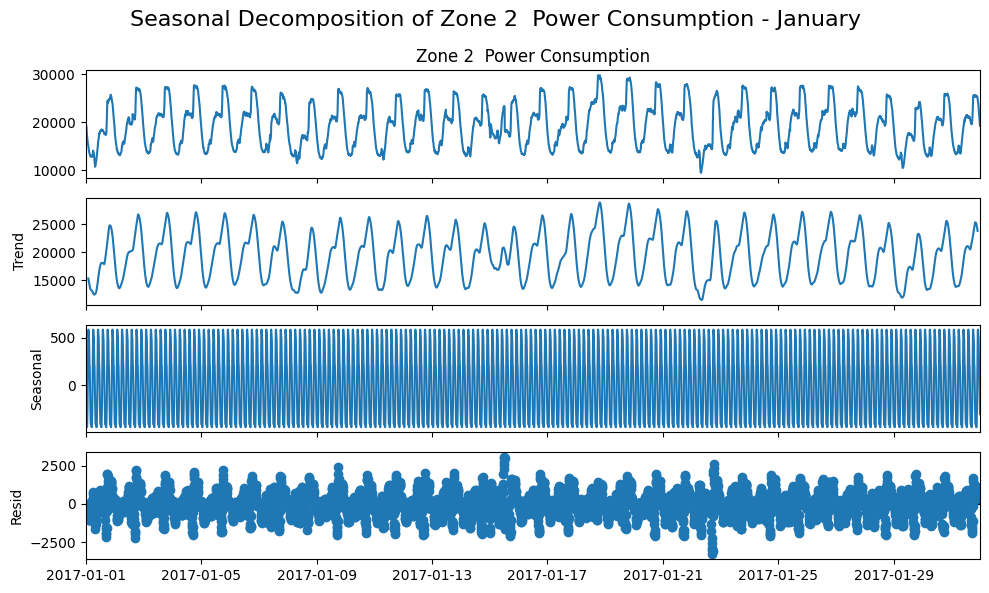

In [ ]:
decompose_monthly_timeseries(df, target_column='Zone 2  Power Consumption', month=1, period=24)


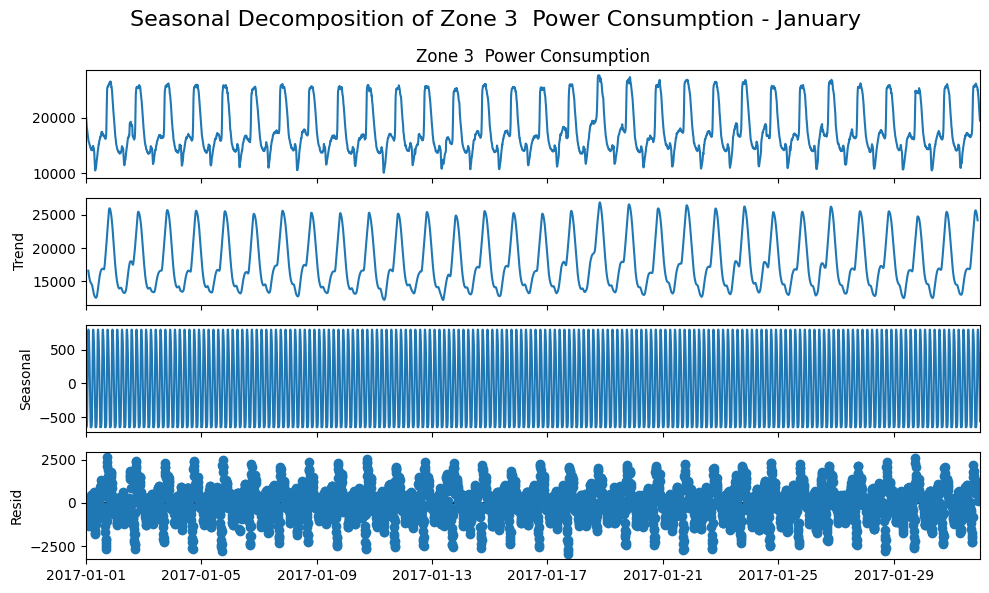

In [ ]:
decompose_monthly_timeseries(df, target_column='Zone 3  Power Consumption', month=1, period=24)


# Decomposition

In [ ]:
final_df.tail()

Zone1     Zone2     Zone3  GDF_max  DF_max  Wind_mean  \
DateTime                                                                        
2017-12-30 19:00:00  2.250829  1.949862  1.015606    0.062   0.119   0.074667   
2017-12-30 20:00:00  2.220532  1.921215  1.019928    0.073   0.145   0.080333   
2017-12-30 21:00:00  2.121490  1.845474  0.996533    0.088   0.134   0.081500   
2017-12-30 22:00:00  2.039605  1.708647  0.936893    0.070   0.122   0.081833   
2017-12-30 23:00:00  1.806479  1.542805  0.848615    0.084   0.111   0.081500   

                     Temp_mean  Humidity_mean  
DateTime                                       
2017-12-30 19:00:00   9.453333      62.406667  
2017-12-30 20:00:00   9.041667      63.990000  
2017-12-30 21:00:00   8.011667      69.675000  
2017-12-30 22:00:00   7.598333      70.315000  
2017-12-30 23:00:00   6.877500      72.900000

# Checking for Stationarity

In [ ]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary, differencing needed")

In [ ]:
for column in final_df:
  print(column)
  result = check_stationarity(final_df[column])
  print(result)
  print('--------------------------------------')

Zone1
ADF Statistic: -4.445856092337989
p-value: 0.0002460164192498004
Data is stationary
None
--------------------------------------
Zone2
ADF Statistic: -4.685281696928967
p-value: 8.967662424157647e-05
Data is stationary
None
--------------------------------------
Zone3
ADF Statistic: -1.261180159380063
p-value: 0.6467401262072529
Data is NOT stationary, differencing needed
None
--------------------------------------
GDF_max
ADF Statistic: -5.460868803550021
p-value: 2.520418972195557e-06
Data is stationary
None
--------------------------------------
DF_max
ADF Statistic: -5.9512866953570835
p-value: 2.1441862277404265e-07
Data is stationary
None
--------------------------------------
Wind_mean
ADF Statistic: -6.530143526820753
p-value: 9.916796327249786e-09
Data is stationary
None
--------------------------------------
Temp_mean
ADF Statistic: -3.081245552489237
p-value: 0.027972594313788308
Data is stationary
None
--------------------------------------
Humidity_mean
ADF Statistic:

 Above we can see that only Diffuse Flow, Wind speed the Humidity are stationary and hence differencing is not needed for them but for the rest we do need differencing

In [ ]:
diff_Zone1 = final_df['Zone1'].diff().dropna()
diff_Zone2 = final_df['Zone2'].diff().dropna()
diff_Zone3 = final_df['Zone3'].diff().dropna()

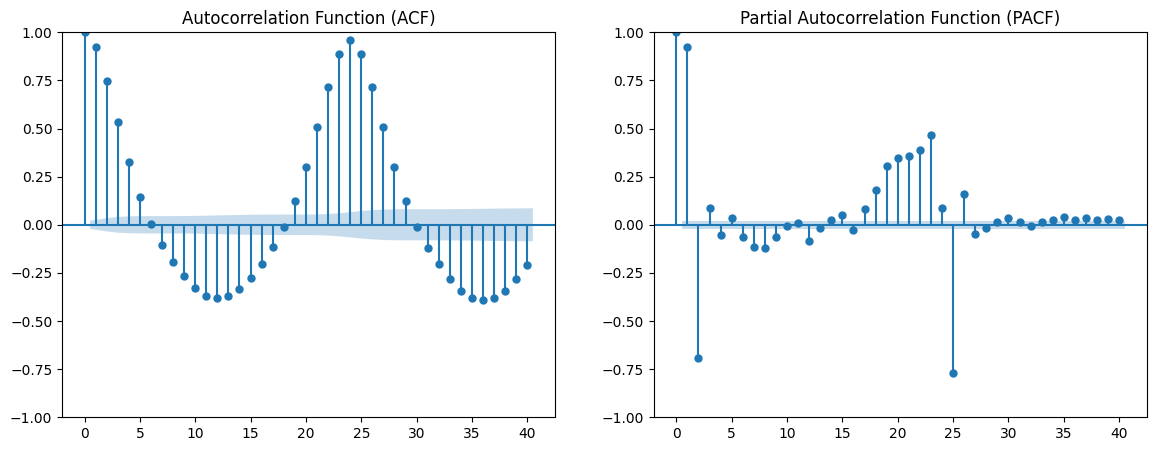

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(final_df['Zone1'], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(final_df['Zone1'], ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

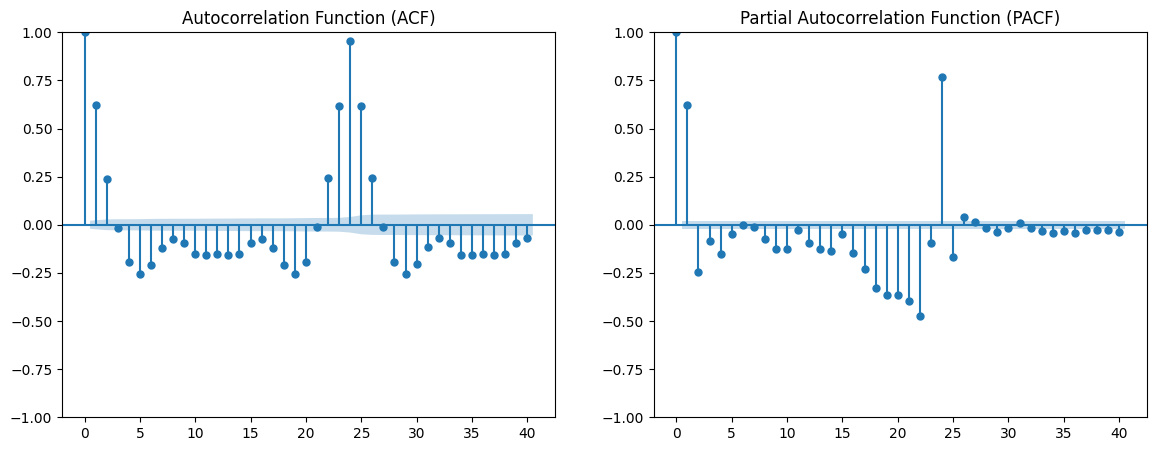

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_Zone1, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(diff_Zone1, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

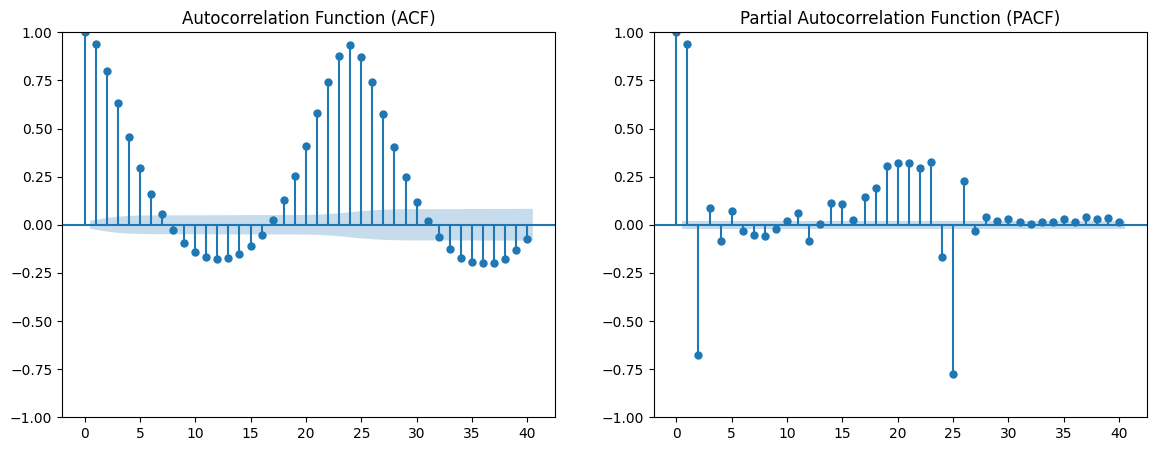

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(final_df['Zone2'], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(final_df['Zone2'], ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

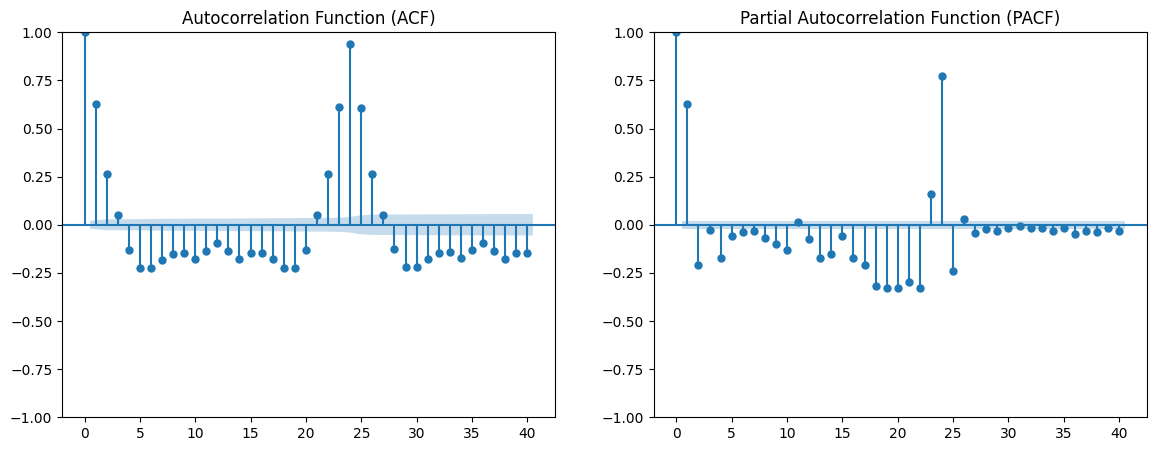

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_Zone2, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(diff_Zone2, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

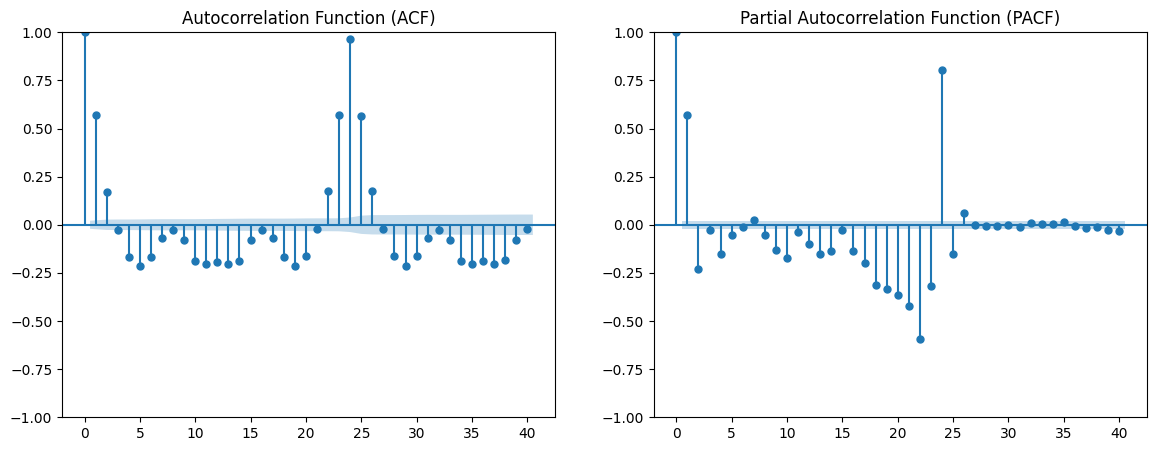

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_Zone3, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(diff_Zone3, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

# Getting the required month

In [ ]:
def get_month_data(df, target_column, month, drop_columns=[]):
    """
    Filters the dataframe for a specific month and returns X and y.

    Args:
        df (pd.DataFrame): Full DataFrame with datetime index.
        target_column (str): Name of the target column.
        month (int): Month number (1=Jan, ..., 12=Dec).
        drop_columns (list): List of columns to drop from X (excluding target).

    Returns:
        X (pd.DataFrame): Features for the selected month.
        y (pd.Series): Target variable for the selected month.
    """
    month_df = df[df.index.month == month]

    y = month_df[target_column]
    X = month_df.drop(columns=[target_column] + drop_columns)

    return X, y


In [ ]:
X, y = get_month_data(
    final_df,
    target_column='Zone1',
    month=1,
    drop_columns=['GDF_max', 'DF_max', 'Wind_mean']
)


In [ ]:
def plot_monthly_timeseries(df, target_column, month):
    """
    Filters the dataframe for a specific month and plots the time series of the target column.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index.
        target_column (str): Column to plot (y-axis).
        month (int): Month to filter (1=Jan, ..., 12=Dec).
    """
    y = df[df.index.month == month][target_column]

    plt.figure(figsize=(12, 5))
    plt.plot(y.index, y.values, label=f'{target_column} Load', color='blue')
    plt.title(f"{target_column} Load - {y.index[0].strftime('%B')}")
    plt.xlabel("Date")
    plt.ylabel(target_column)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


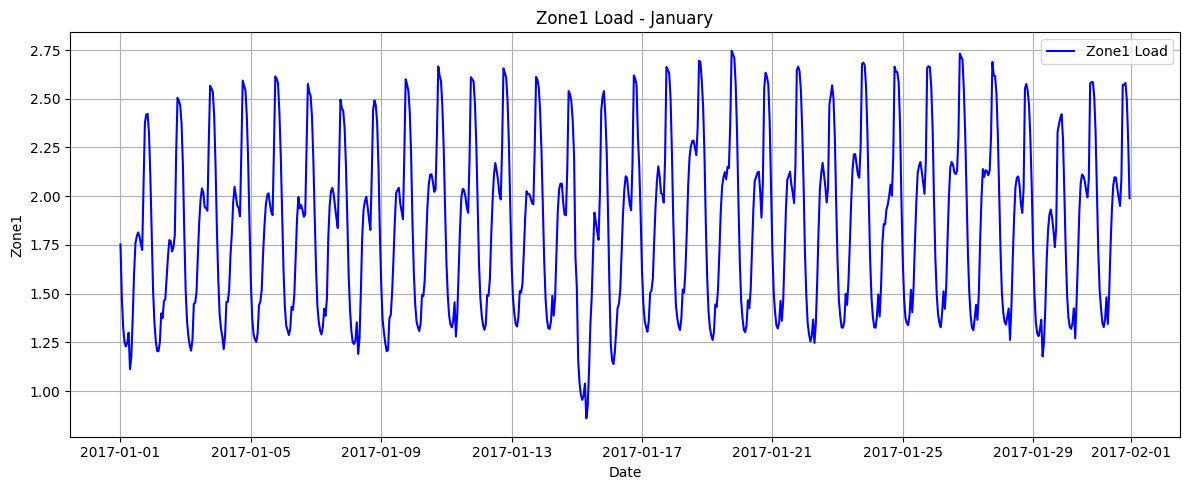

In [ ]:
plot_monthly_timeseries(final_df, target_column='Zone1', month=1)


# __________________________ **TRAIN - VAL - TEST**________________________




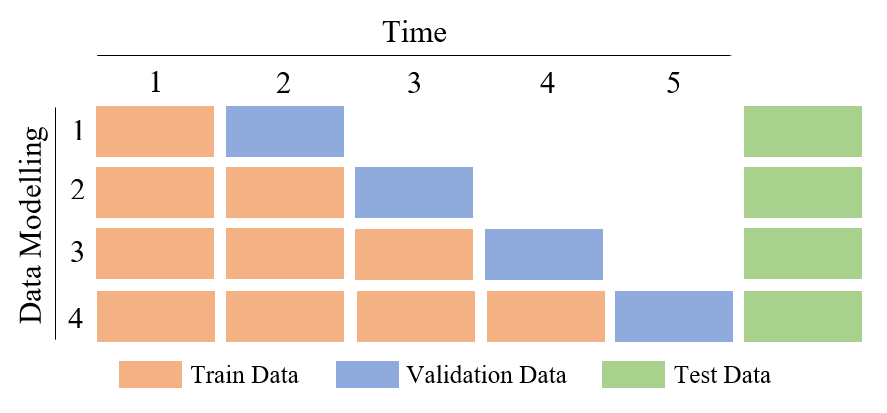

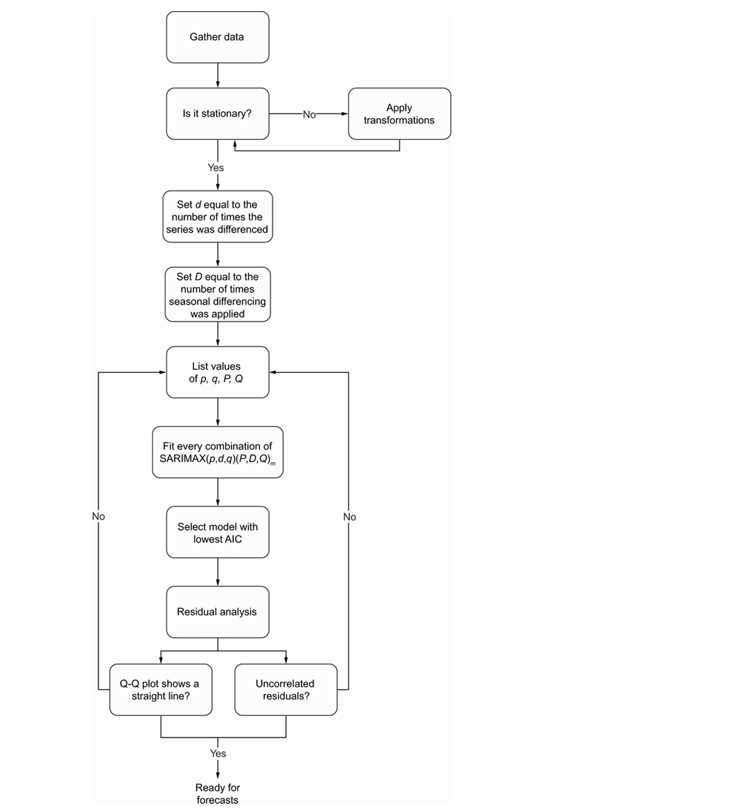

# ARIMA

### ARIMA(6,0,6)

In [ ]:
p_values = range(0, 7,1)
q_values = range(0, 7,1)
pq_combinations = list(product(p_values, q_values))

def optimize_ARIMA(endog: pd.Series, order_list: list, d: int = 0) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
            aic = model.aic
            results.append([(order[0], d, order[1]), aic])
        except:
            continue
    result_df = pd.DataFrame(results, columns=['(p,d,q)', 'AIC']).sort_values(by='AIC').reset_index(drop=True)
    return result_df

ARIMA_result_df = optimize_ARIMA(y, pq_combinations, d=0)

ARIMA_result_df


  0%|          | 0/49 [00:00<?, ?it/s]

(p,d,q)          AIC
0   (6, 0, 6) -1264.961797
1   (6, 0, 4) -1236.039922
2   (5, 0, 2) -1173.449130
3   (6, 0, 3) -1171.008953
4   (6, 0, 5) -1169.742567
5   (5, 0, 3) -1169.194609
6   (5, 0, 4) -1146.718057
7   (4, 0, 4) -1129.046127
8   (2, 0, 6) -1128.157783
9   (3, 0, 3) -1124.162679
10  (6, 0, 2) -1121.740867
11  (0, 0, 6) -1121.220189
12  (4, 0, 3) -1115.303035
13  (5, 0, 5) -1113.630680
14  (5, 0, 6) -1107.862819
15  (2, 0, 5) -1104.706600
16  (1, 0, 5) -1103.984420
17  (4, 0, 5) -1100.264082
18  (4, 0, 6) -1098.966849
19  (3, 0, 6) -1098.856631
20  (3, 0, 2) -1097.530828
21  (2, 0, 4) -1096.533663
22  (2, 0, 3) -1095.822432
23  (4, 0, 2) -1095.300998
24  (1, 0, 6) -1093.319323
25  (2, 0, 2) -1089.333288
26  (3, 0, 5) -1081.443667
27  (3, 0, 4) -1077.642982
28  (4, 0, 0) -1058.933894
29  (4, 0, 1) -1057.048176
30  (5, 0, 0) -1057.042015
31  (6, 0, 0) -1055.194102
32  (5, 0, 1) -1054.994405
33  (6, 0, 1) -1053.043811
34  (2, 0, 0) -1051.124561
35  (2, 0, 1) -1049.607594
36  (3, 0, 0) -1049.438865
37  (3, 0, 1) -1048.870310
38  (0, 0, 5) -1036.112794
39  (1, 0, 4) -1033.373886
40  (1, 0, 3)  -991.582774
41  (1, 0, 2)  -962.922125
42  (1, 0, 1)  -889.846567
43  (0, 0, 4)  -878.286955
44  (0, 0, 3)  -739.173562
45  (1, 0, 0)  -545.656868
46  (0, 0, 2)  -500.570560
47  (0, 0, 1)    60.465196
48  (0, 0, 0)   894.563833

In [ ]:
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train = y[:train_end]
val = y[train_end:val_end]
test = y[val_end:]

model = ARIMA(train, order=(6,0,6)).fit()

val_forecast = model.predict(start=len(train), end=len(train)+len(val)-1, dynamic=True)
test_forecast = model.predict(start=len(train)+len(val), end=n-1)
train_pred = model.predict(start=0, end=train_end-1)

def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    r2 = r2_score(true, pred)
    return rmse, mape, r2


train_metrics = evaluate(train, train_pred)
val_metrics = evaluate(val, val_forecast)
test_metrics = evaluate(test, test_forecast)

print("\n ARIMA(6,0,6) Model Performance:")
print(f"Train  - RMSE: {train_metrics[0]:.2f}, MAPE: {train_metrics[1]:.2%}, R²: {train_metrics[2]:.4f}")
print(f"Val    - RMSE: {val_metrics[0]:.2f}, MAPE: {val_metrics[1]:.2%}, R²: {val_metrics[2]:.4f}")
print(f"Test   - RMSE: {test_metrics[0]:.2f}, MAPE: {test_metrics[1]:.2%}, R²: {test_metrics[2]:.4f}")


 ARIMA(6,0,6) Model Performance:
Train  - RMSE: 0.10, MAPE: 4.10%, R²: 0.9485
Val    - RMSE: 0.46, MAPE: 20.80%, R²: -0.0261
Test   - RMSE: 0.42, MAPE: 20.07%, R²: -0.0191


###------------------------ARIMA(24,0,24)------------------------------------------

In [ ]:
test_size = len(y_test)
tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)

val_preds = []
true_vals = []
val_indices = []

print("Time Series Cross-Validation Metrics:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = ARIMA(y_train_fold, order=(24, 0, 24)).fit()

    forecast = model.get_forecast(steps=len(X_val_fold))
    preds = forecast.predicted_mean.values

    val_preds.extend(preds)
    true_vals.extend(y_val_fold.values)
    val_indices.extend(y_val_fold.index)

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    fold_mape = mean_absolute_percentage_error(y_val_fold, preds) * 100
    fold_r2 = r2_score(y_val_fold, preds)

    print(f"Split {i+1}: RMSE={fold_rmse:.2f}, MAPE={fold_mape:.2f}%, R²={fold_r2:.4f}")


Time Series Cross-Validation Metrics:
Split 1: RMSE=0.20, MAPE=9.00%, R²=0.8221
Split 2: RMSE=0.12, MAPE=5.66%, R²=0.9266
Split 3: RMSE=0.10, MAPE=4.66%, R²=0.9512


In [ ]:
val_rmse = np.sqrt(mean_squared_error(true_vals, val_preds))
val_mape = mean_absolute_percentage_error(true_vals, val_preds) * 100
val_r2 = r2_score(true_vals, val_preds)

print(f"\nAggregated CV Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²: {val_r2:.4f}")


Aggregated CV Metrics:
  RMSE: 0.15
  MAPE: 6.44%
  R²: 0.8986


In [ ]:
ARIMA_model = ARIMA(y_train, order=(24, 0, 24)).fit()

test_forecast = ARIMA_model.get_forecast(steps=len(X_test))
test_pred = test_forecast.predicted_mean.values

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
test_r2 = r2_score(y_test, test_pred)

print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R²: {test_r2:.4f}")




Test Metrics:
  RMSE: 0.11
  MAPE: 4.01%
  R²: 0.9375


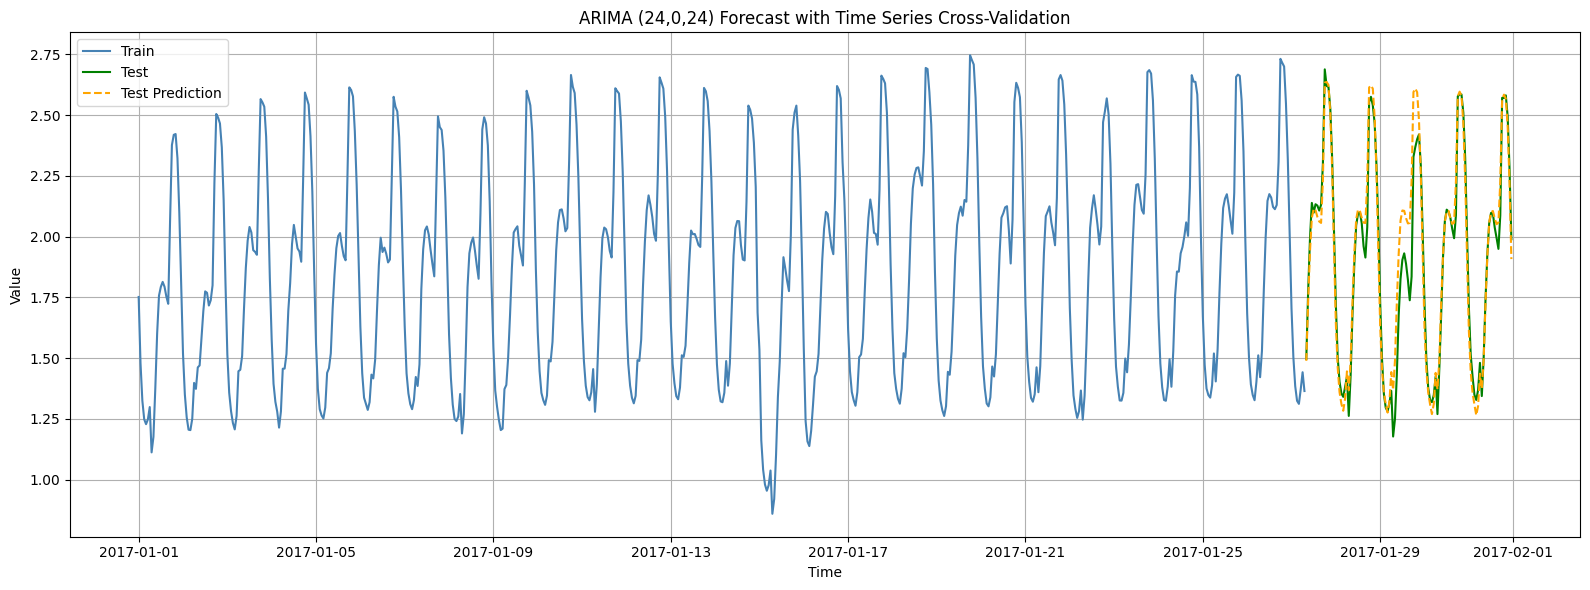

In [ ]:
test_pred_series = pd.Series(test_pred, index=y_test.index)

plt.figure(figsize=(16, 6))
plt.plot(y_train, label='Train', color='steelblue')
plt.plot(y_test, label='Test', color='green')
plt.plot(test_pred_series, '--', label='Test Prediction', color='orange')

plt.title("ARIMA (24,0,24) Forecast with Time Series Cross-Validation")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

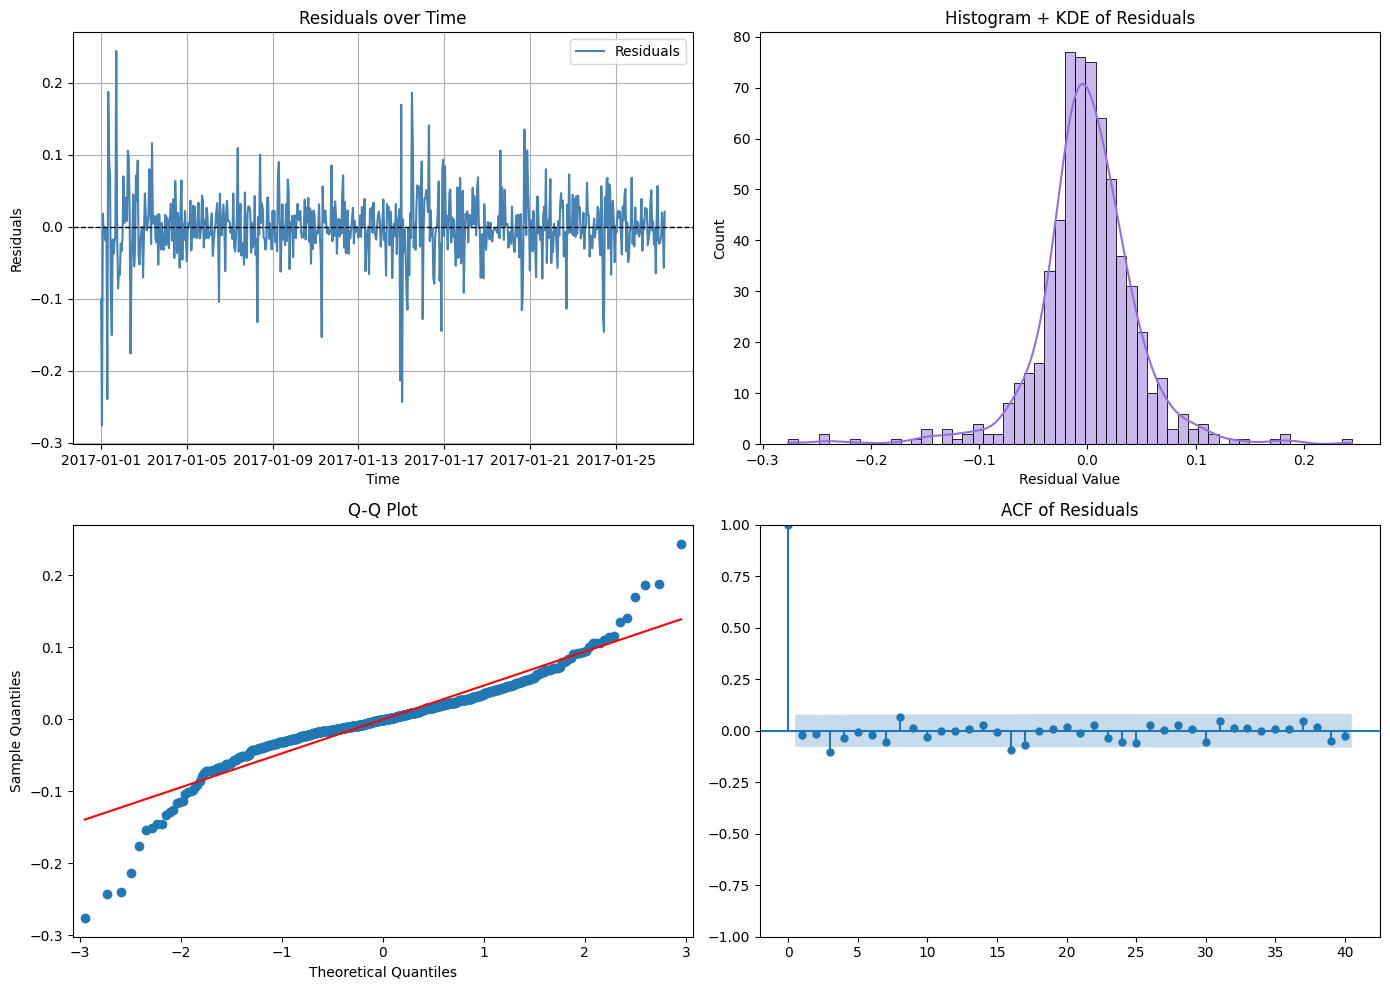

In [ ]:


residuals = ARIMA_model.resid

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(residuals, label='Residuals', color='steelblue')
axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0, 0].set_title('Residuals over Time')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()
axs[0, 0].grid(True)

sns.histplot(residuals, kde=True, ax=axs[0, 1], color='mediumpurple')
axs[0, 1].set_title('Histogram + KDE of Residuals')
axs[0, 1].set_xlabel('Residual Value')

sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

plot_acf(residuals, ax=axs[1, 1], lags=40, alpha=0.05)
axs[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()


## SARIMA

In [ ]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue

    if results:
        result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
        result_df = result_df.sort_values(by='AIC').reset_index(drop=True)
        return result_df
    else:
        return pd.DataFrame(columns=['(p,q,P,Q)', 'AIC'])

In [ ]:
ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 3)
Qs = range(0, 3)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = y[:-5]

d = 1
D = 2
s = 24

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0   (1, 2, 2, 1) -2600.016911
1   (2, 0, 2, 1) -2598.052896
2   (2, 2, 2, 1) -2597.713432
3   (1, 2, 1, 2) -2597.179026
4   (2, 1, 2, 1) -2596.549820
..           ...          ...
76  (0, 0, 2, 2) -1184.038880
77  (0, 0, 0, 1) -1163.478569
78  (0, 0, 2, 0) -1073.298870
79  (0, 0, 1, 0) -1046.801413
80  (0, 0, 0, 0)  -965.593048

[81 rows x 2 columns]

In [ ]:
test_size = int(len(y_test))
tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)

val_preds = []
true_vals = []
val_indices = []

print("Time Series Cross-Validation Metrics:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = SARIMAX(
        y_train_fold,
        order=(2, 1, 2),
        seasonal_order=(1, 2, 2, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = model.get_forecast(steps=len(X_val_fold))
    preds = forecast.predicted_mean.values

    val_preds.extend(preds)
    true_vals.extend(y_val_fold.values)
    val_indices.extend(y_val_fold.index)

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    fold_mape = mean_absolute_percentage_error(y_val_fold, preds) * 100
    fold_r2 = r2_score(y_val_fold, preds)

    print(f"Split {i+1}: RMSE={fold_rmse:.2f}, MAPE={fold_mape:.2f}%, R²={fold_r2:.4f}")

# 3. Aggregated Validation Metrics
val_rmse = np.sqrt(mean_squared_error(true_vals, val_preds))
val_mape = mean_absolute_percentage_error(true_vals, val_preds) * 100
val_r2 = r2_score(true_vals, val_preds)

print(f"\nAggregated CV Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²: {val_r2:.4f}")

Time Series Cross-Validation Metrics:
Split 1: RMSE=0.27, MAPE=14.06%, R²=0.6758
Split 2: RMSE=0.10, MAPE=4.03%, R²=0.9555
Split 3: RMSE=0.08, MAPE=4.05%, R²=0.9672

Aggregated CV Metrics:
  RMSE: 0.17
  MAPE: 7.38%
  R²: 0.8623



Test Metrics:
  RMSE: 0.12
  MAPE: 4.57%
  R²: 0.9199


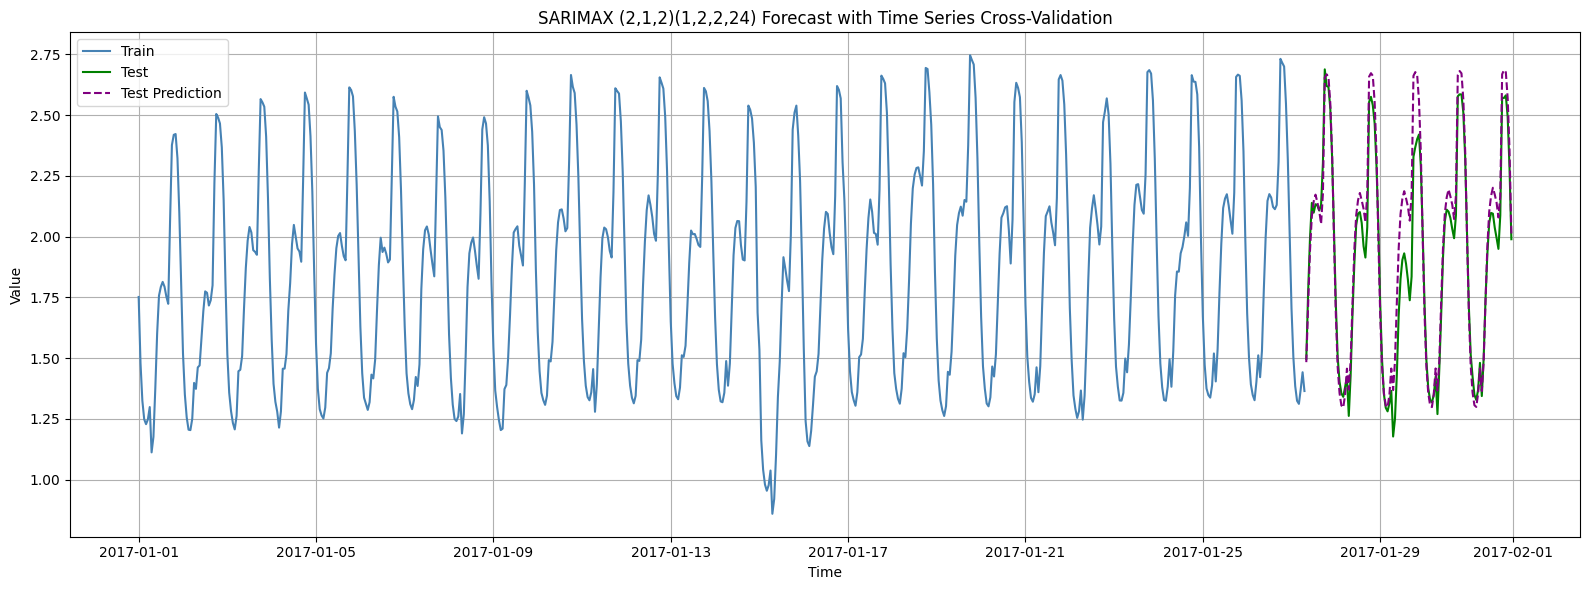

In [ ]:
SARIMA_model = SARIMAX(
    y_train,
    order=(2, 1, 2),
    seasonal_order=(1, 2, 2, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

test_forecast = SARIMA_model.get_forecast(steps=len(X_test))
test_pred = test_forecast.predicted_mean.values

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
test_r2 = r2_score(y_test, test_pred)

print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R²: {test_r2:.4f}")

test_pred_series = pd.Series(test_pred, index=y_test.index)

plt.figure(figsize=(16, 6))
plt.plot(y_train, label='Train', color='steelblue')
plt.plot(y_test, label='Test', color='green')
plt.plot(test_pred_series, '--', label='Test Prediction', color='purple')

plt.title("SARIMAX (2,1,2)(1,2,2,24) Forecast with Time Series Cross-Validation")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

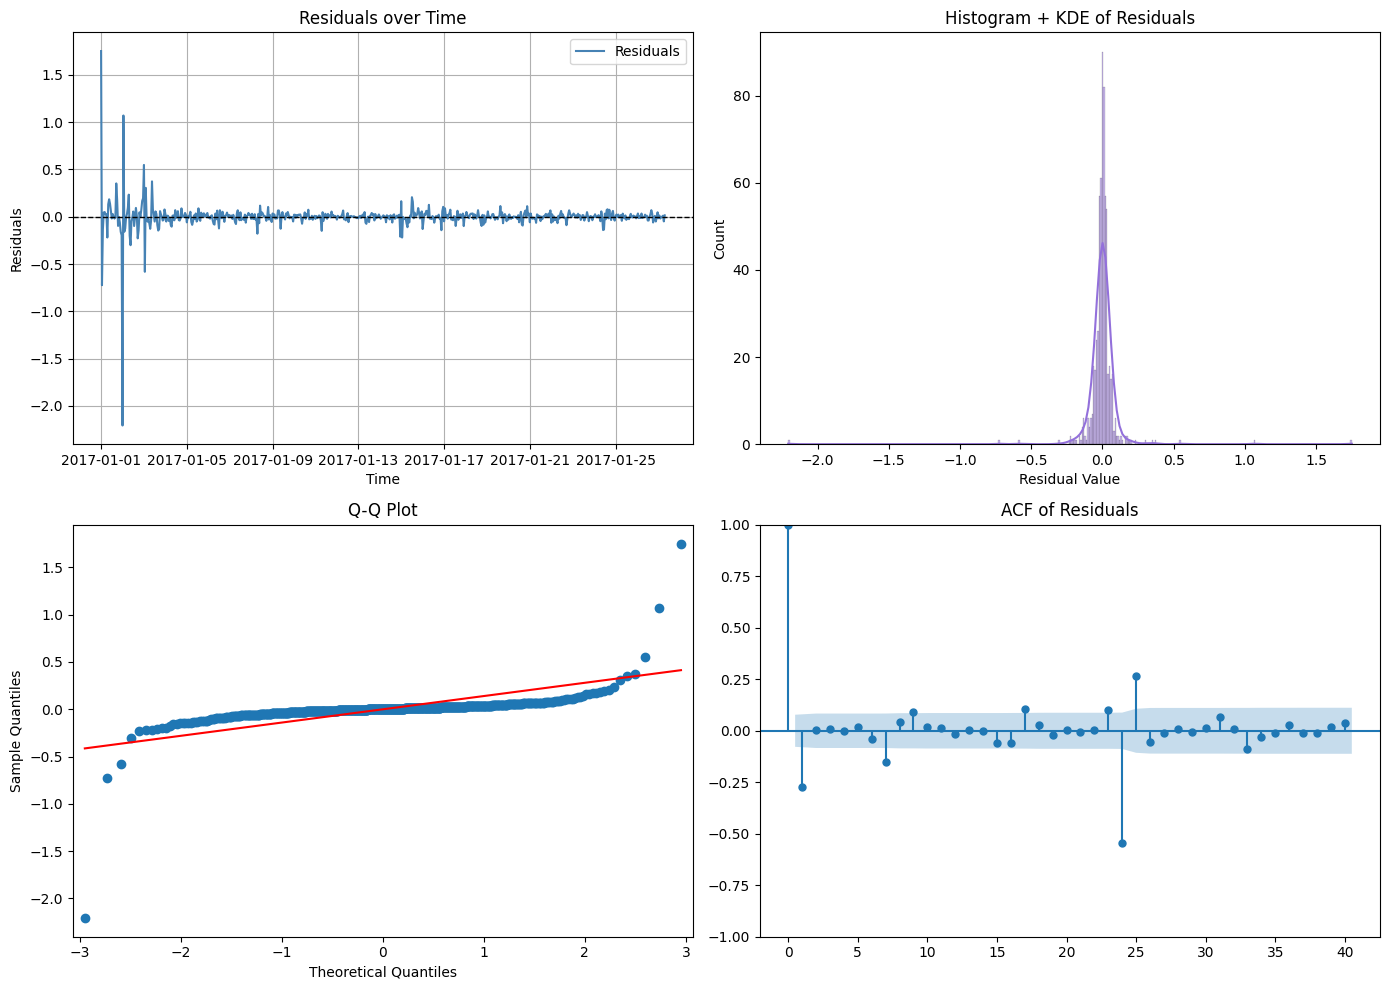

In [ ]:

residuals = SARIMA_model.resid

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(residuals, label='Residuals', color='steelblue')
axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0, 0].set_title('Residuals over Time')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()
axs[0, 0].grid(True)

sns.histplot(residuals, kde=True, ax=axs[0, 1], color='mediumpurple')
axs[0, 1].set_title('Histogram + KDE of Residuals')
axs[0, 1].set_xlabel('Residual Value')

sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

plot_acf(residuals, ax=axs[1, 1], lags=40, alpha=0.05)
axs[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()


# SARIMAX

In [ ]:
test_size = int(len(y_test))
tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)

val_preds = []
true_vals = []
val_indices = []

print("Time Series Cross-Validation Metrics with Exogenous Features:")

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = SARIMAX(
        y_train_fold,
        exog=X_train_fold,
        order=(2, 1, 2),
        seasonal_order=(1, 2, 2, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = model.get_forecast(steps=len(X_val_fold), exog=X_val_fold)
    preds = forecast.predicted_mean.values

    val_preds.extend(preds)
    true_vals.extend(y_val_fold.values)
    val_indices.extend(y_val_fold.index)

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    fold_mape = mean_absolute_percentage_error(y_val_fold, preds) * 100
    fold_r2 = r2_score(y_val_fold, preds)

    print(f"Split {i+1}: RMSE={fold_rmse:.2f}, MAPE={fold_mape:.2f}%, R²={fold_r2:.4f}")

val_rmse = np.sqrt(mean_squared_error(true_vals, val_preds))
val_mape = mean_absolute_percentage_error(true_vals, val_preds) * 100
val_r2 = r2_score(true_vals, val_preds)

print(f"\nAggregated CV Metrics with Exogenous Features:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²: {val_r2:.4f}")

Time Series Cross-Validation Metrics with Exogenous Features:
Split 1: RMSE=0.22, MAPE=9.76%, R²=0.7811
Split 2: RMSE=0.10, MAPE=4.65%, R²=0.9527
Split 3: RMSE=0.16, MAPE=7.56%, R²=0.8795

Aggregated CV Metrics with Exogenous Features:
  RMSE: 0.17
  MAPE: 7.32%
  R²: 0.8697



Test Metrics with exogenous Features:
  RMSE: 0.11
  MAPE: 5.26%
  R²: 0.9354


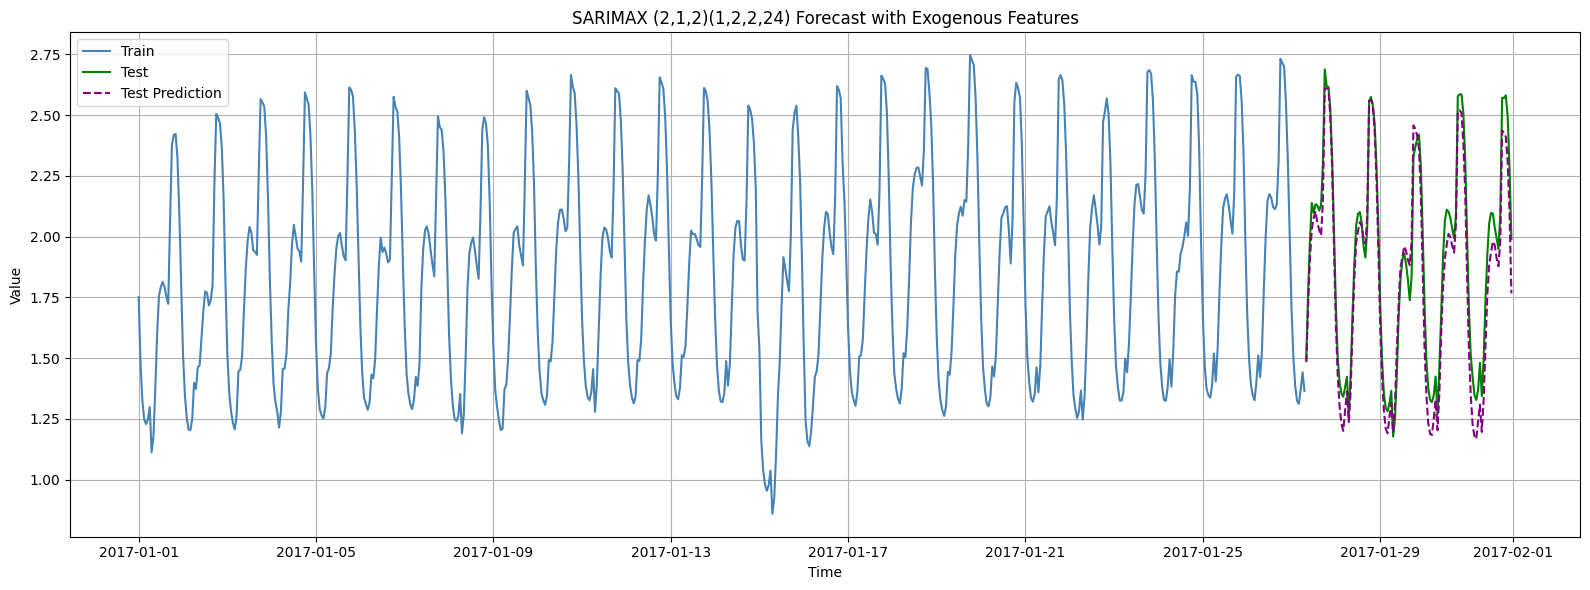

In [ ]:
SARIMAX_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 1, 2),
    seasonal_order=(1, 2, 2, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

test_forecast = SARIMAX_model.get_forecast(steps=len(X_test), exog=X_test)
test_pred = test_forecast.predicted_mean.values

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
test_r2 = r2_score(y_test, test_pred)

print(f"\nTest Metrics with exogenous Features:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R²: {test_r2:.4f}")

test_pred_series = pd.Series(test_pred, index=y_test.index)

plt.figure(figsize=(16, 6))
plt.plot(y_train, label='Train', color='steelblue')
plt.plot(y_test, label='Test', color='green')
plt.plot(test_pred_series, '--', label='Test Prediction', color='purple')

plt.title("SARIMAX (2,1,2)(1,2,2,24) Forecast with Exogenous Features")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


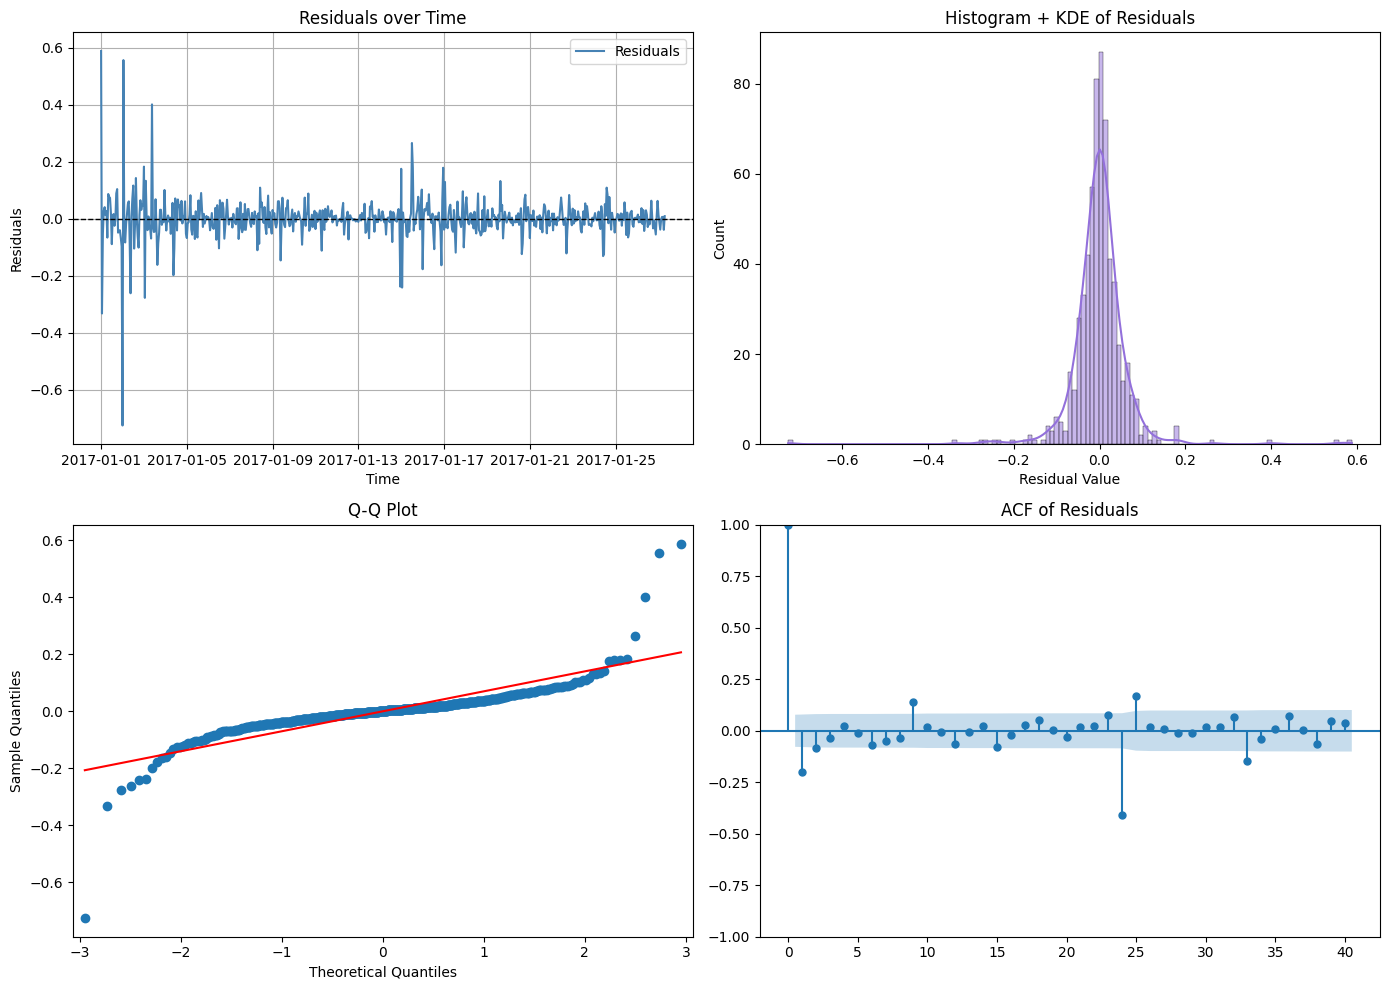

In [ ]:
residuals = SARIMAX_model.resid

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].plot(residuals, label='Residuals', color='steelblue')
axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0, 0].set_title('Residuals over Time')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()
axs[0, 0].grid(True)

sns.histplot(residuals, kde=True, ax=axs[0, 1], color='mediumpurple')
axs[0, 1].set_title('Histogram + KDE of Residuals')
axs[0, 1].set_xlabel('Residual Value')

sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

plot_acf(residuals, ax=axs[1, 1], lags=40, alpha=0.05)
axs[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()


# LSTM and Vanilla RNN

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

def create_sequences(X, y, seq_length=48):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 48
X_seq, y_seq = create_sequences(X, y, seq_length=seq_length)

train_size = int(0.85 * len(X_seq))
X_train, Y_train = X_seq[:train_size], y_seq[:train_size]
X_test, Y_test = X_seq[train_size:], y_seq[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(-1)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

input_size = X_train_tensor.shape[2]
rnn_model = SimpleRNN(input_size=input_size)

criterion = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

def train_model(model, optimizer, train_loader, num_epochs=500, model_name="Model"):
    model.train()
    losses = []
    for epoch in range(1, num_epochs + 1):
        epoch_losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        if epoch % 100 == 0:
            print(f"{model_name} - Epoch [{epoch}/500], Loss: {avg_loss:.4f}")
    return losses

print("Training Simple RNN...")
rnn_losses = train_model(rnn_model, rnn_optimizer, train_loader, num_epochs=500, model_name="Simple RNN")

def evaluate_model(model, X_test_tensor, Y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().cpu().numpy()
    rmse = np.sqrt(mean_squared_error(Y_test, predictions))
    mape = mean_absolute_percentage_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    return rmse, mape, r2, predictions

print("Evaluating RNN...")
rnn_rmse, rnn_mape, rnn_r2, rnn_pred = evaluate_model(rnn_model, X_test_tensor, Y_test)
print(f"RNN -> RMSE: {rnn_rmse:.4f}, MAPE: {rnn_mape:.4f}, R2 Score: {rnn_r2:.4f}")


Training Simple RNN...
Simple RNN - Epoch [100/500], Loss: 0.0187
Simple RNN - Epoch [200/500], Loss: 0.0128
Simple RNN - Epoch [300/500], Loss: 0.0102
Simple RNN - Epoch [400/500], Loss: 0.0105
Simple RNN - Epoch [500/500], Loss: 0.0099
Evaluating RNN...
RNN -> RMSE: 0.1534, MAPE: 0.0606, R2 Score: 0.8726


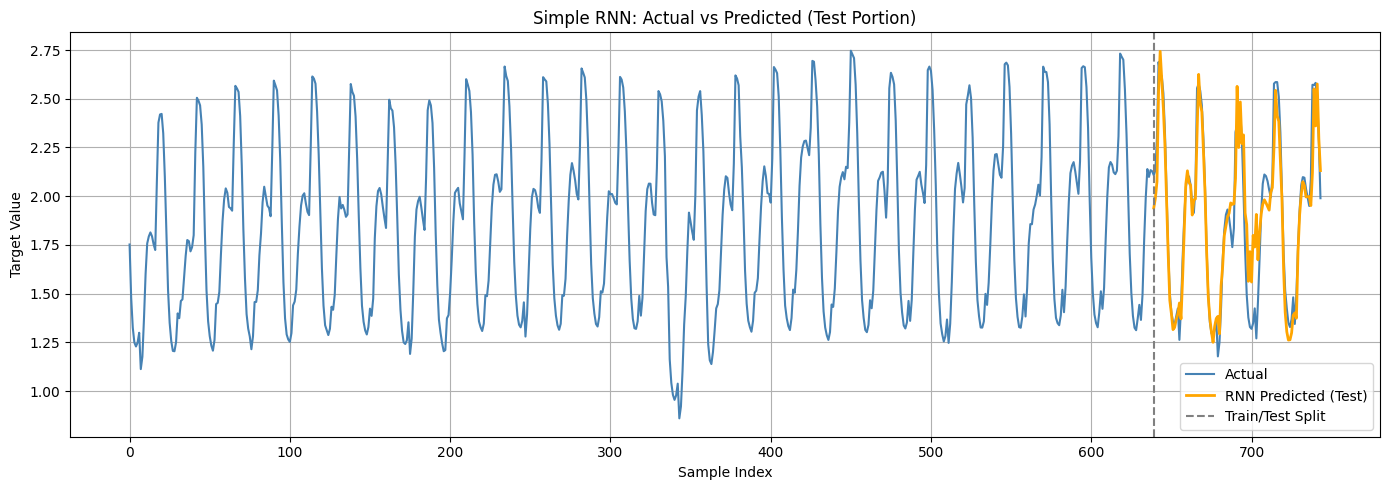

In [ ]:
time_index = np.arange(len(y))

rnn_pred_series = np.full(len(y), np.nan)
rnn_pred_series[-len(rnn_pred):] = rnn_pred

plt.figure(figsize=(14, 5))
plt.plot(time_index, y, label="Actual", color="steelblue")
plt.plot(time_index, rnn_pred_series, label="RNN Predicted (Test)", color="orange", linewidth=2)
plt.axvline(len(y) - len(rnn_pred), color="gray", linestyle="--", label="Train/Test Split")

plt.title("Simple RNN: Actual vs Predicted (Test Portion)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

lstm_model = LSTMModel(input_size=input_size)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print("Training LSTM...")
lstm_losses = train_model(lstm_model, lstm_optimizer, train_loader, num_epochs=500, model_name="LSTM")

print("Evaluating LSTM...")
lstm_rmse, lstm_mape, lstm_r2, lstm_pred = evaluate_model(lstm_model, X_test_tensor, Y_test)
print(f"LSTM -> RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.4f}, R2 Score: {lstm_r2:.4f}")


Training LSTM...
LSTM - Epoch [100/500], Loss: 0.0216
LSTM - Epoch [200/500], Loss: 0.0107
LSTM - Epoch [300/500], Loss: 0.0067
LSTM - Epoch [400/500], Loss: 0.0048
LSTM - Epoch [500/500], Loss: 0.0030
Evaluating LSTM...
LSTM -> RMSE: 0.1122, MAPE: 0.0483, R2 Score: 0.9318


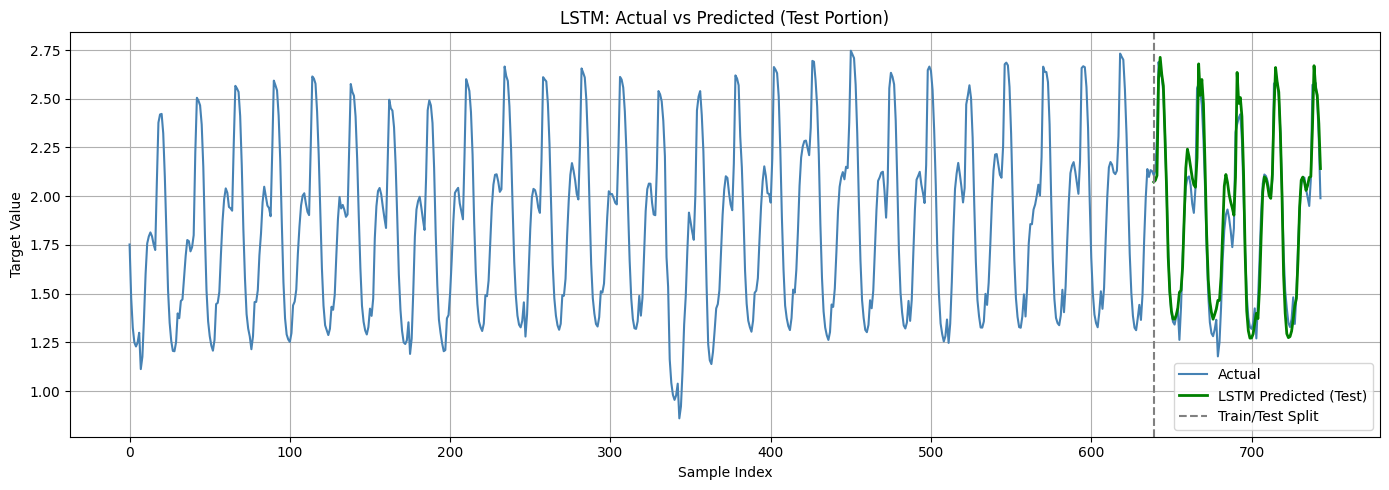

In [ ]:
time_index = np.arange(len(y))

lstm_pred_series = np.full(len(y), np.nan)
lstm_pred_series[-len(lstm_pred):] = lstm_pred

plt.figure(figsize=(14, 5))
plt.plot(time_index, y, label="Actual", color="steelblue")
plt.plot(time_index, lstm_pred_series, label="LSTM Predicted (Test)", color="green", linewidth=2)
plt.axvline(len(y) - len(lstm_pred), color="gray", linestyle="--", label="Train/Test Split")

plt.title("LSTM: Actual vs Predicted (Test Portion)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
''' hidden_sizes = [16, 32]
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]

best_rmse = float('inf')
best_config = None
best_model = None

for hidden_size, lr, batch_size in itertools.product(hidden_sizes, learning_rates, batch_sizes):
    print(f"\nTraining with hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}")

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = SimpleRNN(input_size=input_size, hidden_size=hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, optimizer, train_loader, num_epochs=100, model_name="Tuned RNN")

    rmse, mape, r2, _ = evaluate_model(model, X_test_tensor, Y_test)
    print(f"Evaluation -> RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_config = (hidden_size, lr, batch_size)
        best_model = model

print("\nBest Config:")
print(f"Hidden Size: {best_config[0]}, Learning Rate: {best_config[1]}, Batch Size: {best_config[2]}")
print(f"Best RMSE: {best_rmse:.4f}") '''

# Rough work (For Hypertuning)

In [ ]:
np.random.seed(0)
torch.manual_seed(0)


exog_features = final_df.drop(columns=["Zone1"]).values
target_series = final_df["Zone1"].values

def create_sequences(features, target, seq_length=10):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 48
X_all, y_all = create_sequences(exog_features, target_series, seq_length=seq_length)


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

def evaluate_model(model, X_test_tensor, Y_test_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().cpu().numpy()
    y_true = Y_test_tensor.squeeze().cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mape = mean_absolute_percentage_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)
    return rmse, mape, r2, predictions


In [ ]:
input_size = X_all.shape[2]
output_size = 1

hidden_sizes = [16, 32]
learning_rates = [0.01, 0.005]
batch_sizes = [32, 64]
num_epochs = 1000

tscv = TimeSeriesSplit(n_splits=3)

best_config = None
best_rmse = np.inf

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"\nTrying hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}")
            rmses = []

            for fold, (train_idx, val_idx) in enumerate(tscv.split(X_all)):
                X_train_fold = torch.tensor(X_all[train_idx], dtype=torch.float32)
                Y_train_fold = torch.tensor(y_all[train_idx], dtype=torch.float32).unsqueeze(-1)
                X_val_fold = torch.tensor(X_all[val_idx], dtype=torch.float32)
                Y_val_fold = torch.tensor(y_all[val_idx], dtype=torch.float32).unsqueeze(-1)

                train_dataset = torch.utils.data.TensorDataset(X_train_fold, Y_train_fold)
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

                model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                for epoch in range(num_epochs):
                    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)

                rmse, _, _, _ = evaluate_model(model, X_val_fold, Y_val_fold)
                rmses.append(rmse)

            avg_rmse = np.mean(rmses)
            print(f"Average RMSE: {avg_rmse:.4f}")

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_config = (hidden_size, lr, batch_size)

print(f"\n Best Config: hidden_size={best_config[0]}, lr={best_config[1]}, batch_size={best_config[2]} (RMSE={best_rmse:.4f})")



Trying hidden_size=16, lr=0.01, batch_size=32
Average RMSE: 0.3172

Trying hidden_size=16, lr=0.01, batch_size=64
Average RMSE: 0.2659

Trying hidden_size=16, lr=0.005, batch_size=32
Average RMSE: 0.2533

Trying hidden_size=16, lr=0.005, batch_size=64
Average RMSE: 0.2373

Trying hidden_size=32, lr=0.01, batch_size=32
Average RMSE: 0.3038

Trying hidden_size=32, lr=0.01, batch_size=64
Average RMSE: 0.2823

Trying hidden_size=32, lr=0.005, batch_size=32
Average RMSE: 0.2974

Trying hidden_size=32, lr=0.005, batch_size=64
Average RMSE: 0.2569

✅ Best Config: hidden_size=16, lr=0.005, batch_size=64 (RMSE=0.2373)


In [ ]:
hidden_size = 16
learning_rate = 0.005
batch_size = 64
num_epochs = 1000

tscv = TimeSeriesSplit(n_splits=3, test_size=int(0.2 * len(X_all)))

rmse_list, mape_list, r2_list = [], [], []

for fold, (train_index, val_index) in enumerate(tscv.split(X_all)):
    print(f"\nFold {fold + 1}:")

    X_train, X_val = X_all[train_index], X_all[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_size=X_all.shape[2], hidden_size=hidden_size, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor).squeeze().numpy()
        actuals = y_val_tensor.squeeze().numpy()

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds)
    r2 = r2_score(actuals, preds)

    print(f"RMSE: {rmse:.4f} | MAPE: {mape*100:.2f}% | R2: {r2:.4f}")

    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)




Fold 1:


KeyboardInterrupt: 

In [ ]:
test_split_index = int(0.85 * len(X_all))
X_train_final, y_train_final = X_all[:test_split_index], y_all[:test_split_index]
X_test, y_test = X_all[test_split_index:], y_all[test_split_index:]

X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

model = LSTMModel(input_size=X_all.shape[2], hidden_size=hidden_size, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).squeeze().numpy()
    test_actuals = y_test_tensor.squeeze().numpy()

test_rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
test_mape = mean_absolute_percentage_error(test_actuals, test_preds)
test_r2 = r2_score(test_actuals, test_preds)

print("\n==== Cross-Validation Averages ====")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list)*100:.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

print("\n==== Final Test Set Metrics ====")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAPE: {test_mape*100:.2f}%")
print(f"R2: {test_r2:.4f}")

# GRU

In [ ]:

np.random.seed(0)
torch.manual_seed(0)

target_series = y
exog_features = X

def create_sequences(features, target, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 48
X_seq, y_seq = create_sequences(exog_features, target_series, seq_length)

train_size = int(0.8 * len(X_seq))
X_train, Y_train = X_seq[:train_size], y_seq[:train_size]
X_test, Y_test = X_seq[train_size:], y_seq[train_size:]

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(-1)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

input_dim = X_train.shape[2]
model = GRUNet(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 500
losses = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    if (epoch + 1) % 100 == 0:
        print(f"GRU - Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    y_true = Y_test_tensor.squeeze().numpy()



GRU - Epoch [100/500], Loss: 0.0091
GRU - Epoch [200/500], Loss: 0.0037
GRU - Epoch [300/500], Loss: 0.0029
GRU - Epoch [400/500], Loss: 0.0021
GRU - Epoch [500/500], Loss: 0.0013



RMSE: 0.11
MAPE: 4.19%
R2  : 0.9400


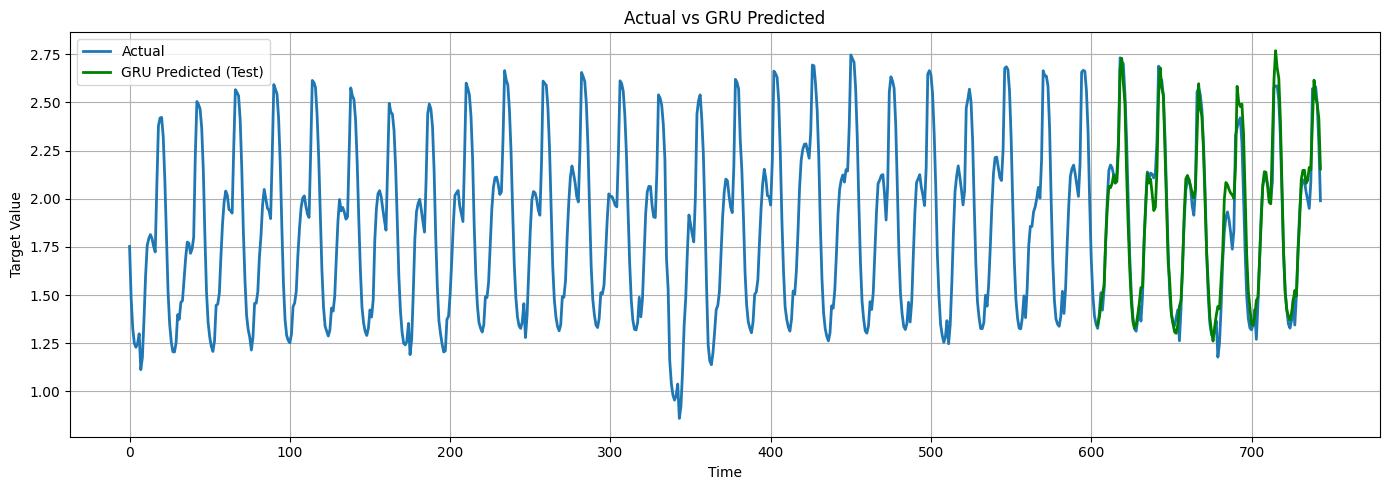

In [ ]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nRMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R2  : {r2:.4f}")

import matplotlib.pyplot as plt

y_true = Y_test_tensor.squeeze().numpy()
y_pred = y_pred.squeeze()

time_index = np.arange(len(y))

train_len = len(y) - len(y_true)
gru_pred_series = np.full(len(y), np.nan)
gru_pred_series[train_len:] = y_pred

plt.figure(figsize=(14, 5))
plt.plot(time_index, y, label="Actual", linewidth=2)
plt.plot(time_index, gru_pred_series, label="GRU Predicted (Test)", color="green", linewidth=2)
plt.title("Actual vs GRU Predicted")
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
''' import itertools

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

hidden_dims = [32, 64]
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]

best_gru_rmse = float('inf')
best_gru_config = None
best_gru_model = None

for hidden_dim, lr, batch_size in itertools.product(hidden_dims, learning_rates, batch_sizes):
    print(f"\nTraining GRU with hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}")

    # Create DataLoader for each batch_size
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Build model
    model = GRUNet(input_dim, hidden_dim=hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    n_epochs = 500
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
        y_true = Y_test_tensor.squeeze().numpy()
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"  Evaluation RMSE: {rmse:.4f}")

    if rmse < best_gru_rmse:
        best_gru_rmse = rmse
        best_gru_config = (hidden_dim, lr, batch_size)
        best_gru_model = model

print("\nBest GRU Configuration:")
print(f"Hidden Dim: {best_gru_config[0]}, Learning Rate: {best_gru_config[1]}, Batch Size: {best_gru_config[2]}")
print(f"Best RMSE: {best_gru_rmse:.4f}")
'''

' import itertools\n\nclass GRUNet(nn.Module):\n    def __init__(self, input_dim, hidden_dim=64):\n        super(GRUNet, self).__init__()\n        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)\n        self.fc = nn.Linear(hidden_dim, 1)\n\n    def forward(self, x):\n        out, _ = self.gru(x)\n        return self.fc(out[:, -1, :])\n\nhidden_dims = [32, 64]\nlearning_rates = [0.01, 0.001]\nbatch_sizes = [32, 64]\n\nbest_gru_rmse = float(\'inf\')\nbest_gru_config = None\nbest_gru_model = None\n\nfor hidden_dim, lr, batch_size in itertools.product(hidden_dims, learning_rates, batch_sizes):\n    print(f"\nTraining GRU with hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}")\n    \n    # Create DataLoader for each batch_size\n    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)\n    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\n    \n    # Build model\n    model = GRUNet(input_dim, hidden_

# XGBOOST

In [ ]:
total_len = len(y)
train_len = int(0.85 * total_len)

X_train_full, X_test = X[:train_len], X[train_len:]
y_train_full, y_test = y[:train_len], y[train_len:]

xgb_params = {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05}

n_splits = 3
fold_sizes = np.linspace(int(0.4 * train_len), train_len, n_splits + 1, dtype=int)[1:]

results = []

for fold, fold_end in enumerate(fold_sizes, 1):
    fold_data = X_train_full[:fold_end]
    fold_target = y_train_full[:fold_end]

    val_size = int(0.2 * len(fold_data))
    train_size = len(fold_data) - val_size

    X_fold_train, y_fold_train = fold_data[:train_size], fold_target[:train_size]
    X_fold_val, y_fold_val = fold_data[train_size:], fold_target[train_size:]

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_fold_train, y_fold_train)

    y_val_pred = model.predict(X_fold_val)

    rmse = np.sqrt(mean_squared_error(y_fold_val, y_val_pred))
    mape = mean_absolute_percentage_error(y_fold_val, y_val_pred)
    r2 = r2_score(y_fold_val, y_val_pred)

    results.append((f"Fold {fold}", rmse, mape, r2))
    print(f"Fold {fold} -> RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_train_full, y_train_full)
y_test_pred = final_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

results.append(("Test Set", test_rmse, test_mape, test_r2))
print(f"\nTest Set  -> RMSE: {test_rmse:.4f}, MAPE: {test_mape:.4f}, R2: {test_r2:.4f}")

df_results = pd.DataFrame(results, columns=["Fold", "RMSE", "MAPE", "R2"])

Fold 1 -> RMSE: 0.2731, MAPE: 0.1428, R2: 0.6782
Fold 2 -> RMSE: 0.1246, MAPE: 0.0507, R2: 0.9241
Fold 3 -> RMSE: 0.1488, MAPE: 0.0490, R2: 0.8910

Test Set  -> RMSE: 0.0873, MAPE: 0.0379, R2: 0.9568


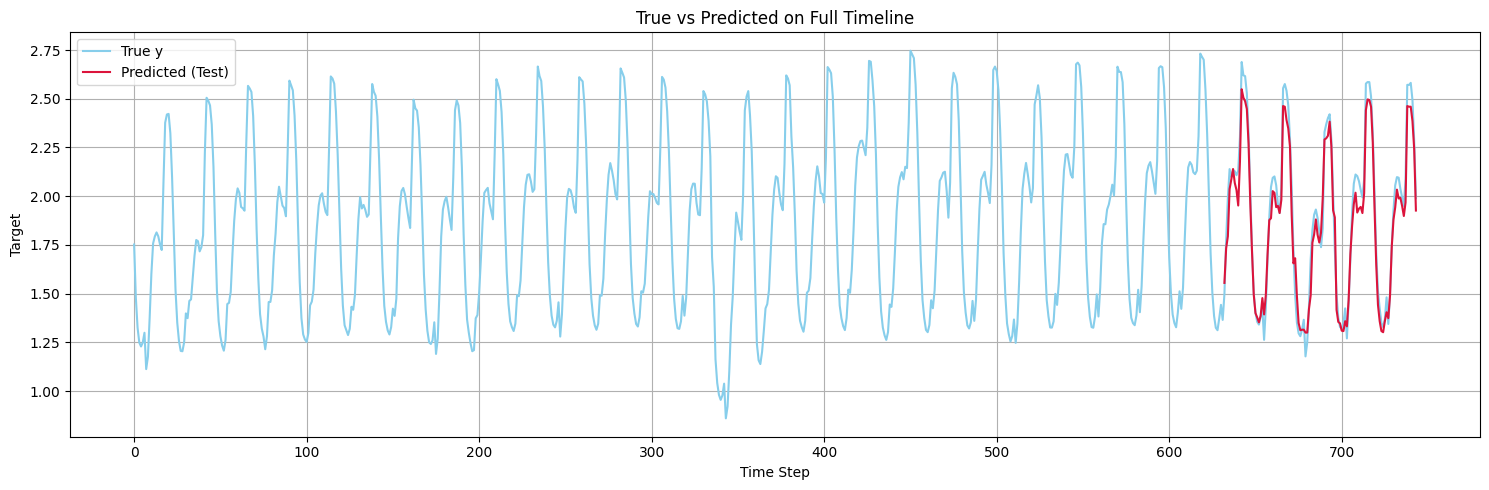


Evaluation Results:
       Fold      RMSE      MAPE        R2
0    Fold 1  0.273078  0.142805  0.678170
1    Fold 2  0.124582  0.050713  0.924122
2    Fold 3  0.148784  0.048987  0.891032
3  Test Set  0.087288  0.037885  0.956839


In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(y)), y, label="True y", color='skyblue')
plt.plot(np.arange(train_len, total_len), y_test_pred, label="Predicted (Test)", color='crimson')
plt.title("True vs Predicted on Full Timeline")
plt.xlabel("Time Step")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nEvaluation Results:")
print(df_results)


# Random forest

Fold 1 → RMSE: 0.1412, MAPE: 0.0627, R²: 0.8897
Fold 2 → RMSE: 0.1954, MAPE: 0.0835, R²: 0.8237
Fold 3 → RMSE: 0.1386, MAPE: 0.0444, R²: 0.9069

Test Set → RMSE: 0.0808, MAPE: 0.0351, R²: 0.9630

Results Summary:
       Fold      RMSE      MAPE        R²
0    Fold 1  0.141151  0.062697  0.889664
1    Fold 2  0.195446  0.083467  0.823723
2    Fold 3  0.138646  0.044432  0.906890
3  Test Set  0.080771  0.035097  0.963044


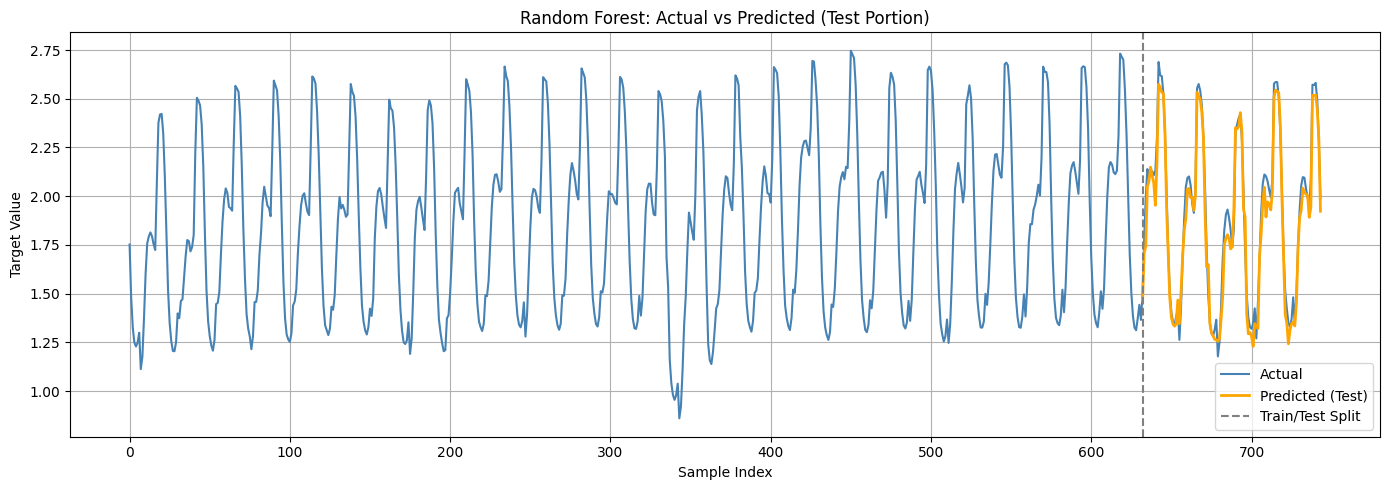

In [ ]:

train_len = int(0.85 * len(y))

X_train_full, X_test = X[:train_len], X[train_len:]
y_train_full, y_test = y[:train_len], y[train_len:]

X_train_flat = np.array(X_train_full).reshape(X_train_full.shape[0], -1)
X_test_flat = np.array(X_test).reshape(X_test.shape[0], -1)

rf_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'max_depth': None,
    'random_state': 0
}

val_size = int(0.2 * len(X_train_flat))
tscv = TimeSeriesSplit(n_splits=3)

results = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_flat), 1):
    X_tr, X_val = X_train_flat[train_idx], X_train_flat[val_idx]
    y_tr, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    results.append((f"Fold {fold}", rmse, mape, r2))
    print(f"Fold {fold} → RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R²: {r2:.4f}")

final_model = RandomForestRegressor(**rf_params)
final_model.fit(X_train_flat, y_train_full)

y_test_pred = final_model.predict(X_test_flat)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

results.append(("Test Set", test_rmse, test_mape, test_r2))
print(f"\nTest Set → RMSE: {test_rmse:.4f}, MAPE: {test_mape:.4f}, R²: {test_r2:.4f}")

df_results = pd.DataFrame(results, columns=["Fold", "RMSE", "MAPE", "R²"])
print("\nResults Summary:")
print(df_results)

plt.figure(figsize=(14, 5))
time_index = np.arange(len(y))
plt.plot(time_index, y, label="Actual", color="steelblue")

pred_full = np.full(len(y), np.nan)
pred_full[train_len:] = y_test_pred
plt.plot(time_index, pred_full, label="Predicted (Test)", color="orange", linewidth=2)

plt.axvline(train_len, color="gray", linestyle="--", label="Train/Test Split")
plt.title("Random Forest: Actual vs Predicted (Test Portion)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
